<a href="https://colab.research.google.com/github/anushkaw055/GANS/blob/master/gans_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import tensorflow as tf

In [3]:
import matplotlib.pyplot as plt
import os, time  
import numpy as np 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from keras.backend.tensorflow_backend import set_session

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [4]:
dir_data = '/content/drive/My Drive/dataset/test'
train        = 60 
test         = 40
nm_imgs       = np.sort(os.listdir(dir_data))
## name of the jpg files for training set
nm_imgs_train = nm_imgs[:train]
## name of the jpg files for the testing data
nm_imgs_test  = nm_imgs[train:train + test]
img_shape     = (32, 32, 3)

def get_npdata(nm_imgs_train):
    X_train = []
    for i, myid in enumerate(nm_imgs_train):
        image = load_img(dir_data + "/" + myid,
                         target_size=img_shape[:2])
        image = img_to_array(image)/255.0      # normalization
        X_train.append(image)
    X_train = np.array(X_train)
    return(X_train)

X_train = get_npdata(nm_imgs_train)
print("X_train.shape = {}".format(X_train.shape))

X_test  = get_npdata(nm_imgs_test)
print("X_test.shape = {}".format(X_test.shape))

X_train.shape = (60, 32, 32, 3)
X_test.shape = (40, 32, 32, 3)


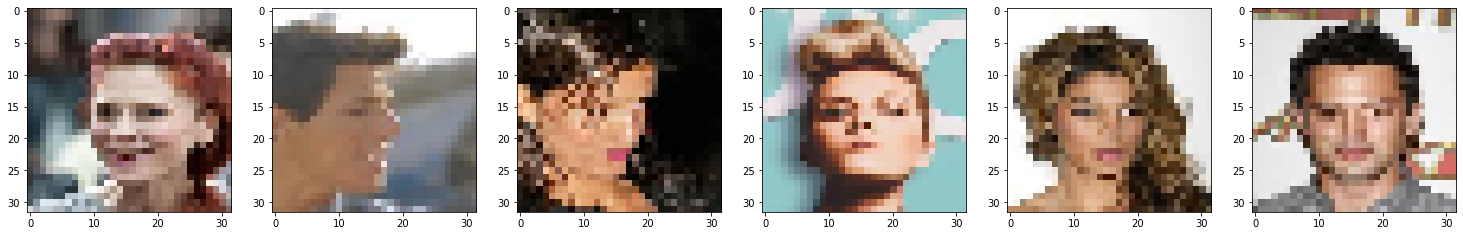

In [5]:
fig = plt.figure(figsize=(30,10))
nplot = 7
for count in range(1,nplot):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(X_train[count])
plt.show()

In [6]:
from keras import layers, models
from keras.optimizers import Adam

## optimizer
#optimizer = Adam(0.0002, 0.5)
optimizer = Adam(0.00007, 0.5)

def build_generator(img_shape, noise_shape = (100,)):
    '''
    noise_shape : the dimension of the input vector for the generator
    img_shape   : the dimension of the output
    '''
    ## latent variable as input
    input_noise = layers.Input(shape=noise_shape) 
    d = layers.Dense(1024, activation="relu")(input_noise) 
    d = layers.Dense(1024, activation="relu")(input_noise) 
    d = layers.Dense(128*8*8, activation="relu")(d)
    d = layers.Reshape((8,8,128))(d)
    
    d = layers.Conv2DTranspose(128, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
    d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_4")(d) ## 16,16


    d = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
    d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_5")(d) ## 32,32
    
    if img_shape[0] == 64:
        d = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
        d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_6")(d) ## 64,64
    
    img = layers.Conv2D( 3 , ( 1 , 1 ) , activation='sigmoid' , padding='same', name="final_block")(d) ## 32, 32
    model = models.Model(input_noise, img)
    model.summary() 
    return(model)

## Set the dimension of latent variables to be 100
noise_shape = (100,)

generator = build_generator(img_shape, noise_shape = noise_shape)

generator.compile(loss='binary_crossentropy', optimizer=optimizer)




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dense_3 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       65536     
_________________________________________________________________
block_4 (Conv2D)             (None, 16, 16, 64)        8256      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 32)        8

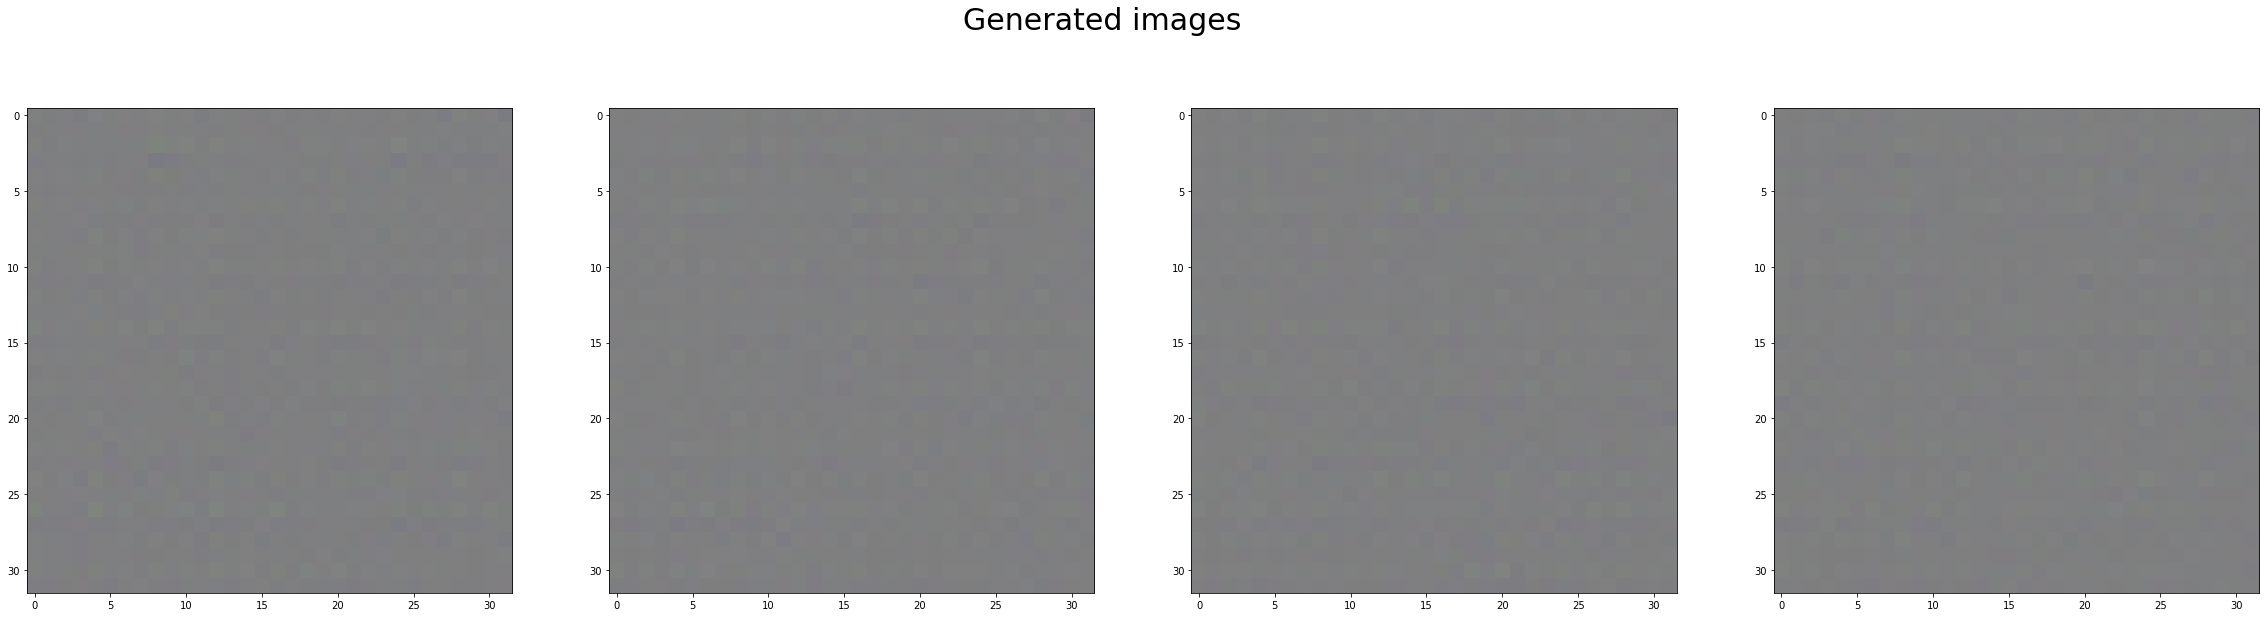

In [7]:
def get_noise(nsample=1, nlatent_dim=100):
    noise = np.random.normal(0, 1, (nsample,nlatent_dim))
    return(noise)

def plot_generated_images(noise,path_save=None,titleadd=""):
    imgs = generator.predict(noise)
    fig = plt.figure(figsize=(40,10))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1,nsample,i+1)
        ax.imshow(img)
    fig.suptitle("Generated images "+titleadd,fontsize=30)
    
    if path_save is not None:
        plt.savefig(path_save,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.close()
    else:
        plt.show()

nsample = 4
noise = get_noise(nsample=nsample, nlatent_dim=noise_shape[0])
plot_generated_images(noise)

In [8]:
def build_discriminator(img_shape,noutput=1):
    input_img = layers.Input(shape=img_shape)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_img)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(1, 1), name='block4_pool')(x)

    
    x         = layers.Flatten()(x)
    x         = layers.Dense(1024,      activation="relu")(x)
    out       = layers.Dense(noutput,   activation='sigmoid')(x)
    model     = models.Model(input_img, out)
    
    return model

discriminator  = build_discriminator(img_shape)
discriminator.compile(loss      = 'binary_crossentropy', 
                      optimizer = optimizer,
                      metrics   = ['accuracy'])

discriminator.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 32)        896       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 32)        9248      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 64)        18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 64)          0  

In [9]:
z = layers.Input(shape=noise_shape)
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = models.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 3)         8584515   
_________________________________________________________________
model_2 (Model)              (None, 1)                 6711585   
Total params: 15,296,100
Trainable params: 8,584,515
Non-trainable params: 6,711,585
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 00000 [D loss: 0.720, acc.: 028.6%] [G loss: 0.658]


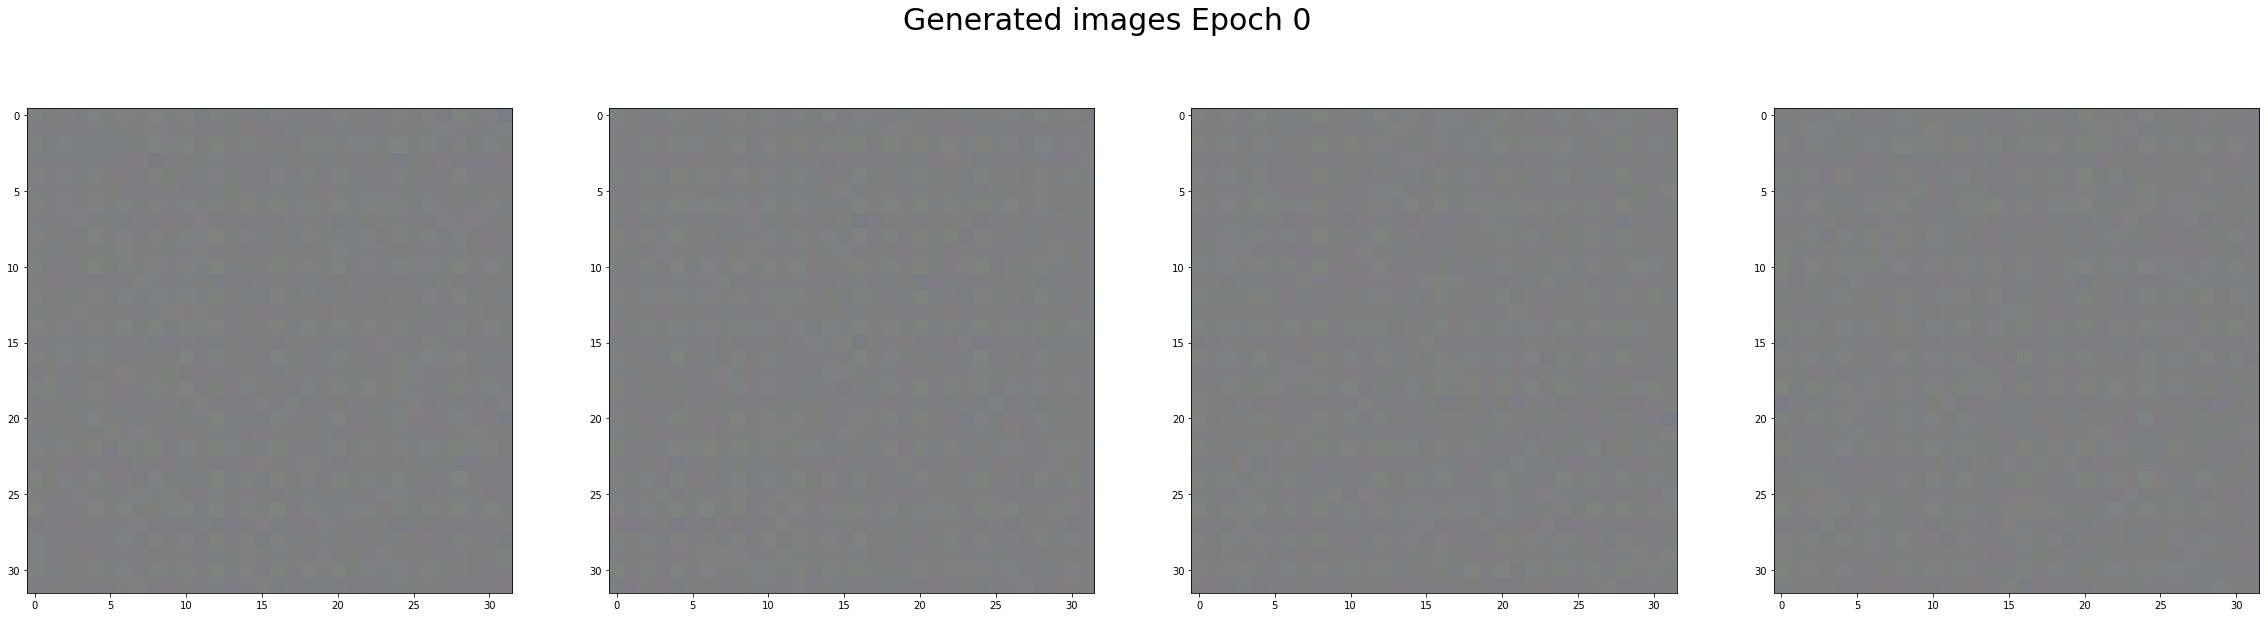

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 00100 [D loss: 0.147, acc.: 099.4%] [G loss: 2.160]
Epoch 00200 [D loss: 0.418, acc.: 083.4%] [G loss: 1.962]
Epoch 00300 [D loss: 0.367, acc.: 086.1%] [G loss: 1.703]
Epoch 00400 [D loss: 0.200, acc.: 094.7%] [G loss: 2.459]
Epoch 00500 [D loss: 0.142, acc.: 098.2%] [G loss: 4.318]
Epoch 00600 [D loss: 0.033, acc.: 100.0%] [G loss: 3.719]
Epoch 00700 [D loss: 0.099, acc.: 097.6%] [G loss: 4.131]
Epoch 00800 [D loss: 0.201, acc.: 090.7%] [G loss: 2.753]
Epoch 00900 [D loss: 0.176, acc.: 097.4%] [G loss: 3.661]
Epoch 01000 [D loss: 0.138, acc.: 096.6%] [G loss: 3.910]


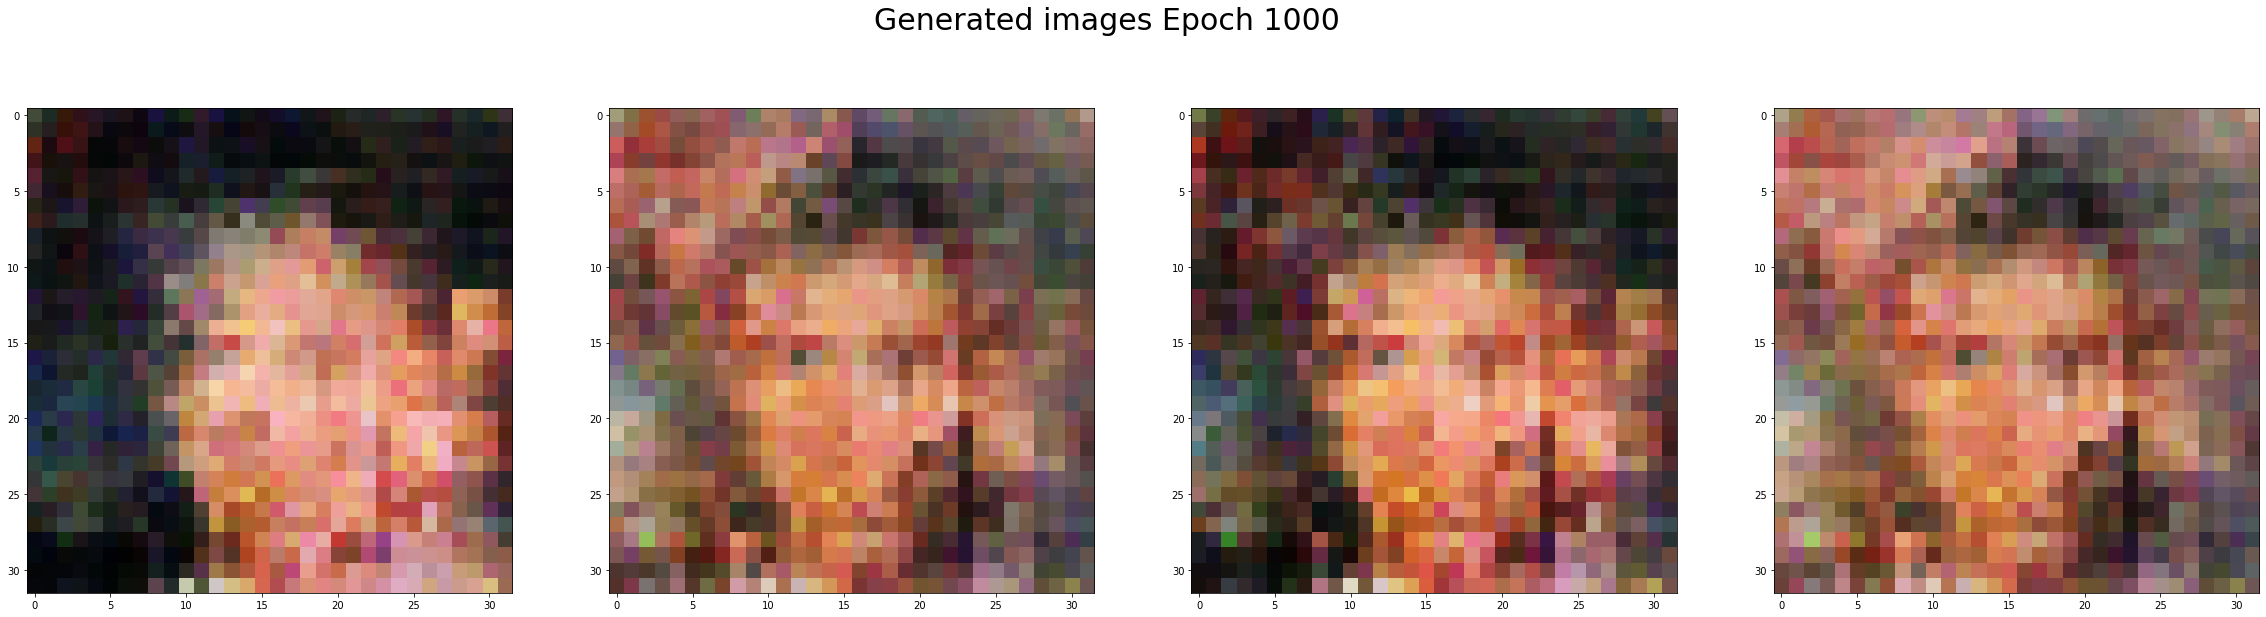

Epoch 01100 [D loss: 0.083, acc.: 099.5%] [G loss: 3.693]
Epoch 01200 [D loss: 0.162, acc.: 093.5%] [G loss: 3.103]
Epoch 01300 [D loss: 0.271, acc.: 090.9%] [G loss: 4.324]
Epoch 01400 [D loss: 0.116, acc.: 097.3%] [G loss: 4.218]
Epoch 01500 [D loss: 0.093, acc.: 100.0%] [G loss: 2.994]
Epoch 01600 [D loss: 0.197, acc.: 092.0%] [G loss: 5.607]
Epoch 01700 [D loss: 0.088, acc.: 097.6%] [G loss: 4.756]
Epoch 01800 [D loss: 0.130, acc.: 097.6%] [G loss: 5.489]
Epoch 01900 [D loss: 0.029, acc.: 099.9%] [G loss: 4.670]
Epoch 02000 [D loss: 0.040, acc.: 099.8%] [G loss: 6.061]


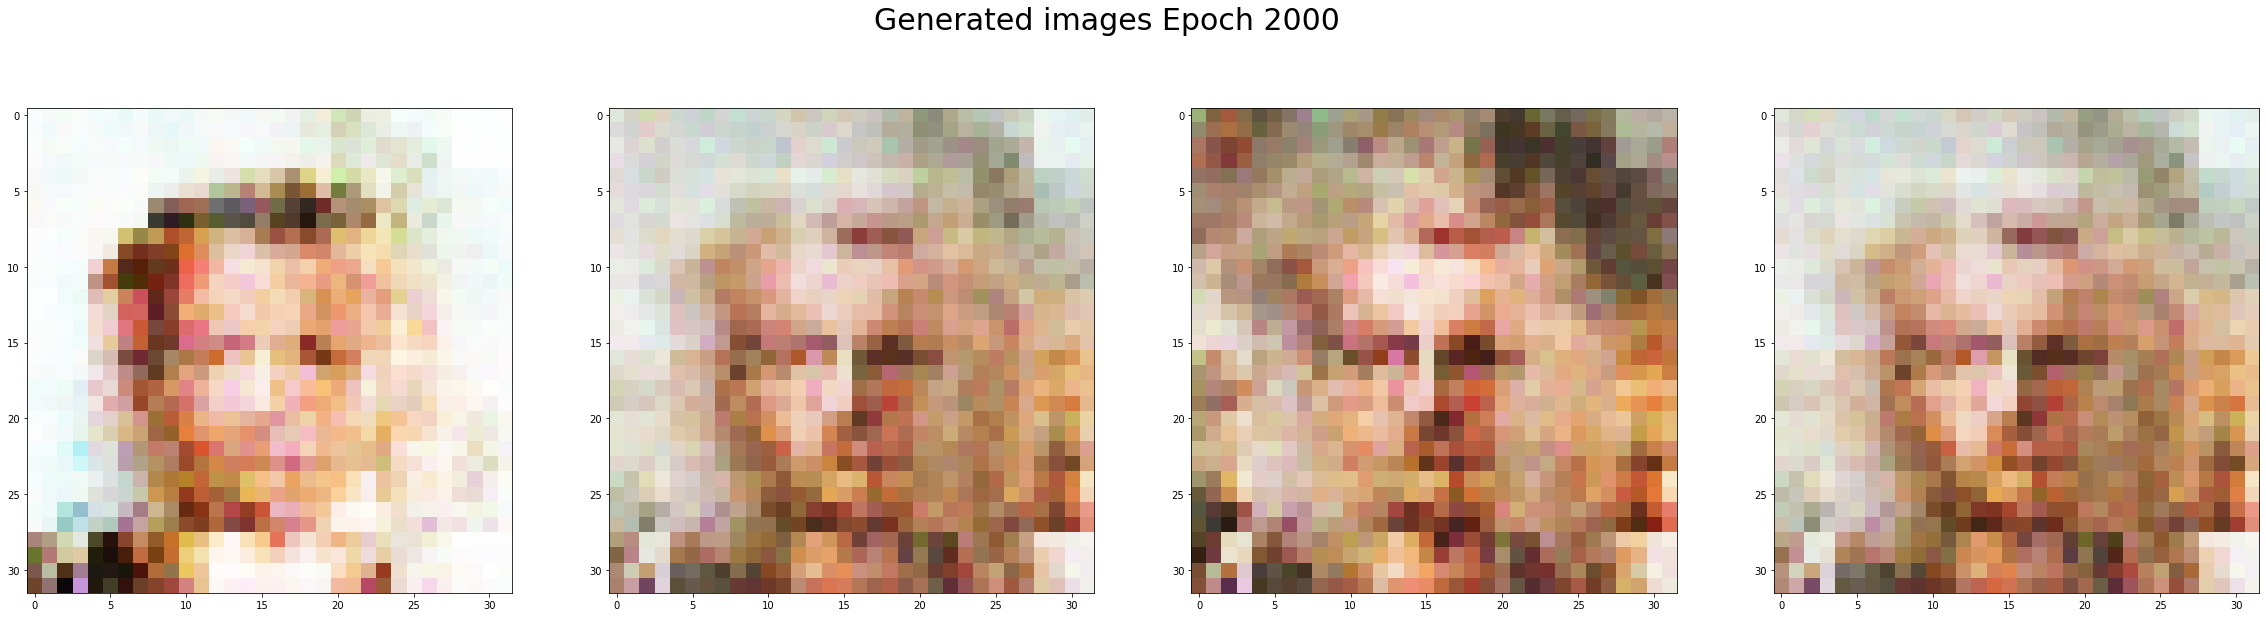

Epoch 02100 [D loss: 0.015, acc.: 100.0%] [G loss: 5.890]
Epoch 02200 [D loss: 0.086, acc.: 097.9%] [G loss: 5.521]
Epoch 02300 [D loss: 0.019, acc.: 099.8%] [G loss: 6.156]
Epoch 02400 [D loss: 0.066, acc.: 100.0%] [G loss: 3.771]
Epoch 02500 [D loss: 0.045, acc.: 099.2%] [G loss: 5.494]
Epoch 02600 [D loss: 0.024, acc.: 100.0%] [G loss: 4.791]
Epoch 02700 [D loss: 0.026, acc.: 100.0%] [G loss: 5.704]
Epoch 02800 [D loss: 0.016, acc.: 100.0%] [G loss: 5.558]
Epoch 02900 [D loss: 0.036, acc.: 100.0%] [G loss: 4.059]
Epoch 03000 [D loss: 0.079, acc.: 098.5%] [G loss: 3.279]


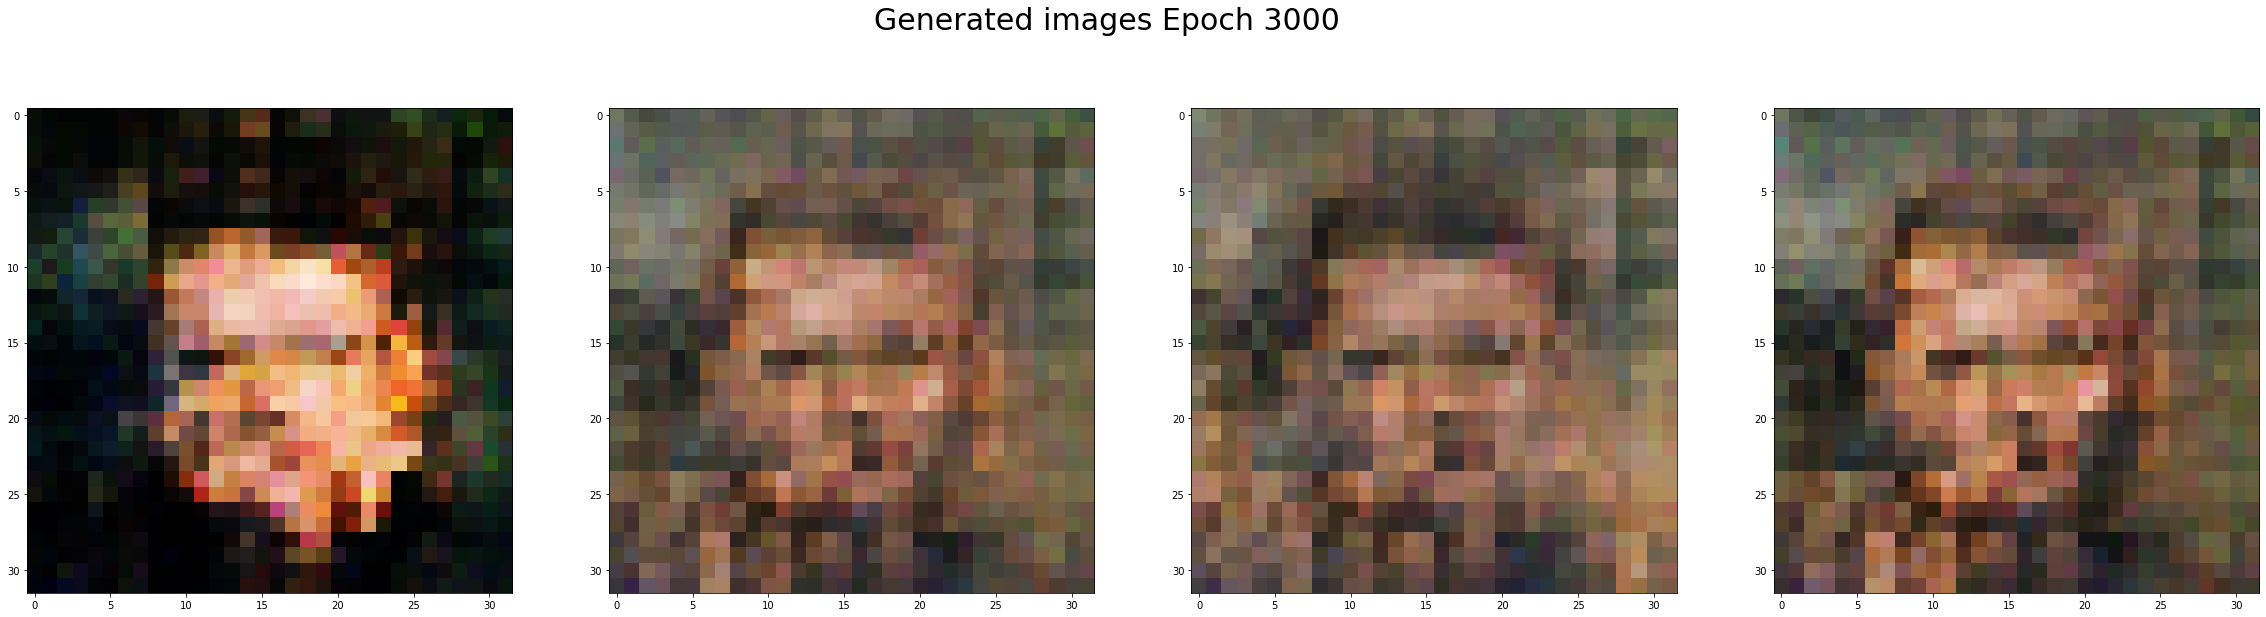

Epoch 03100 [D loss: 0.044, acc.: 099.8%] [G loss: 4.921]
Epoch 03200 [D loss: 0.029, acc.: 100.0%] [G loss: 4.564]
Epoch 03300 [D loss: 0.027, acc.: 098.8%] [G loss: 5.203]
Epoch 03400 [D loss: 0.123, acc.: 097.1%] [G loss: 3.874]
Epoch 03500 [D loss: 0.020, acc.: 100.0%] [G loss: 4.844]
Epoch 03600 [D loss: 0.010, acc.: 100.0%] [G loss: 6.120]
Epoch 03700 [D loss: 0.010, acc.: 100.0%] [G loss: 6.436]
Epoch 03800 [D loss: 0.008, acc.: 100.0%] [G loss: 7.027]
Epoch 03900 [D loss: 0.022, acc.: 099.9%] [G loss: 6.180]
Epoch 04000 [D loss: 0.016, acc.: 100.0%] [G loss: 5.398]


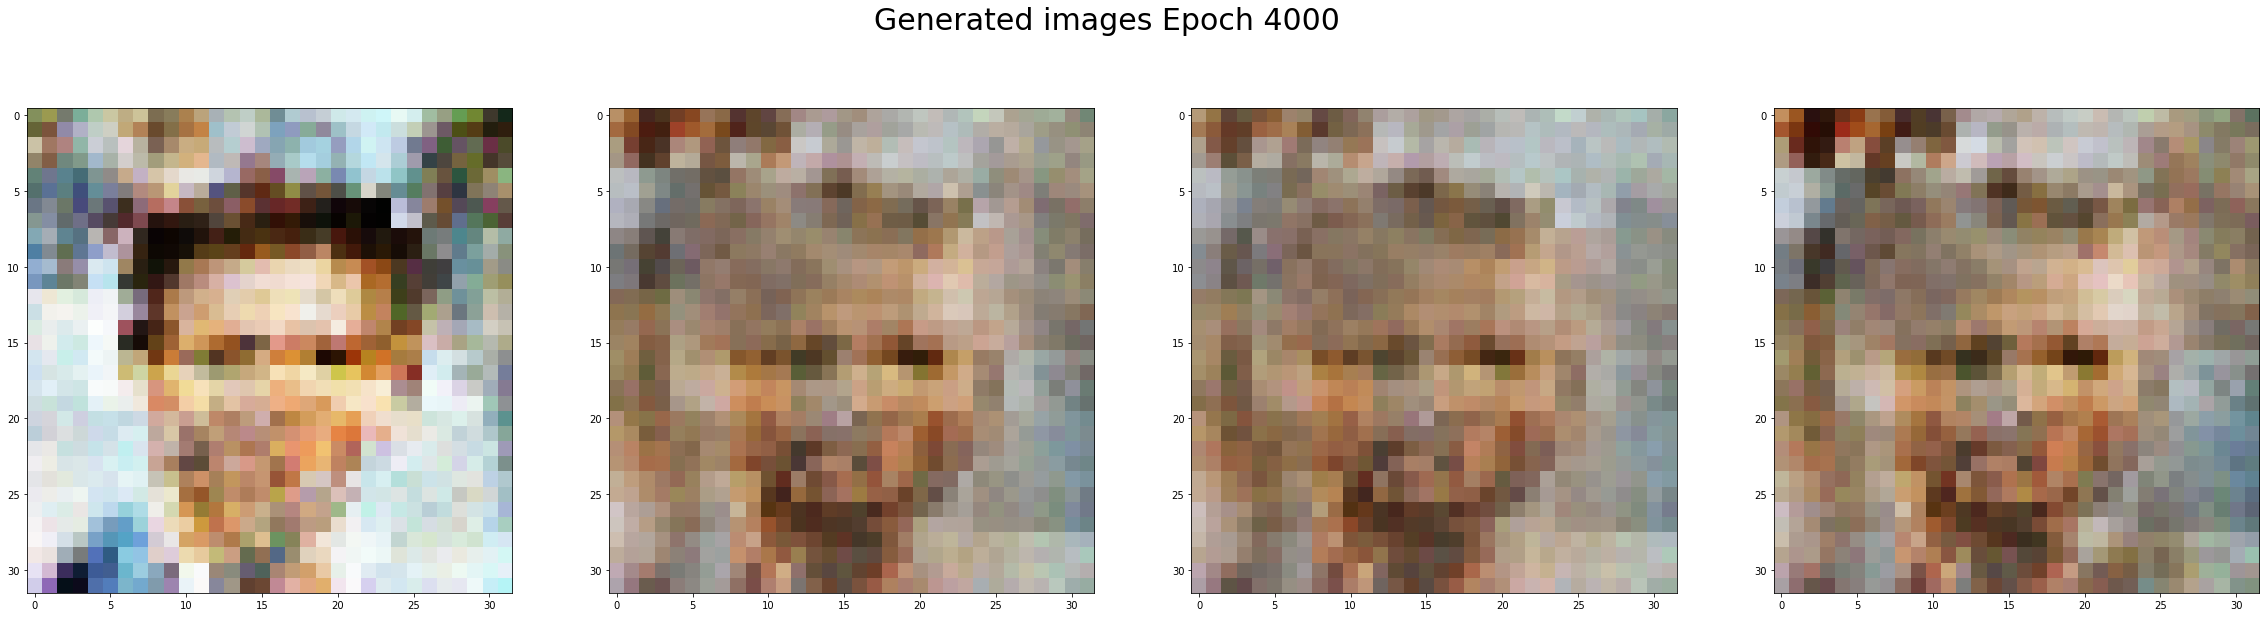

Epoch 04100 [D loss: 0.036, acc.: 100.0%] [G loss: 5.741]
Epoch 04200 [D loss: 0.014, acc.: 100.0%] [G loss: 5.829]
Epoch 04300 [D loss: 0.023, acc.: 100.0%] [G loss: 4.886]
Epoch 04400 [D loss: 0.020, acc.: 100.0%] [G loss: 6.059]
Epoch 04500 [D loss: 0.007, acc.: 100.0%] [G loss: 6.543]
Epoch 04600 [D loss: 0.012, acc.: 100.0%] [G loss: 5.854]
Epoch 04700 [D loss: 0.010, acc.: 100.0%] [G loss: 7.624]
Epoch 04800 [D loss: 0.006, acc.: 100.0%] [G loss: 7.703]
Epoch 04900 [D loss: 0.024, acc.: 100.0%] [G loss: 4.230]
Epoch 05000 [D loss: 0.021, acc.: 100.0%] [G loss: 5.516]


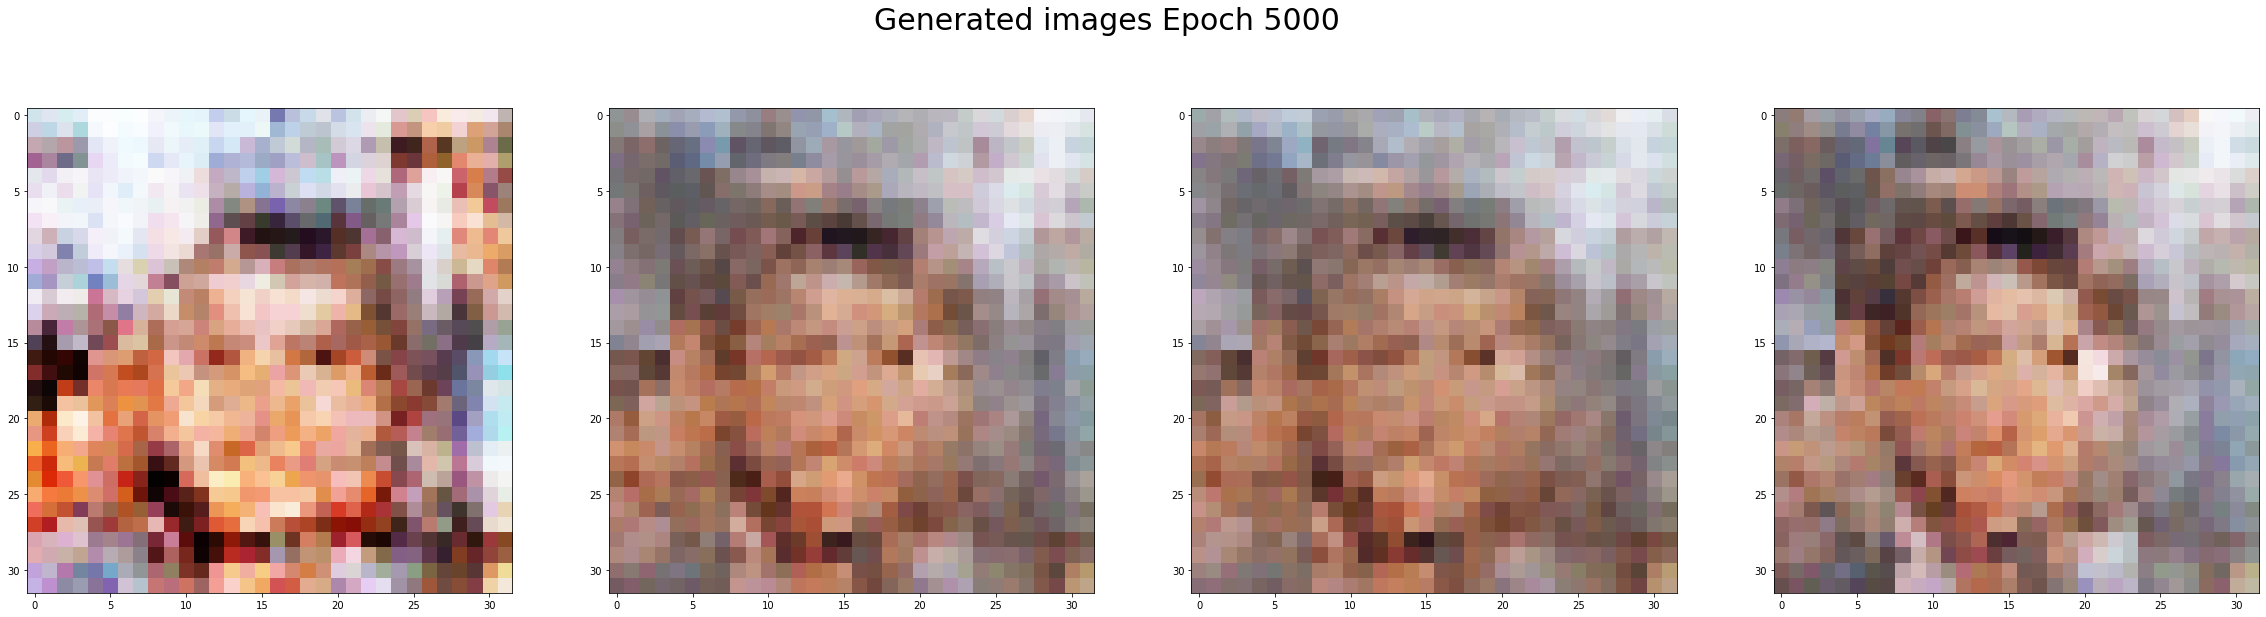

Epoch 05100 [D loss: 0.129, acc.: 099.1%] [G loss: 5.653]
Epoch 05200 [D loss: 0.013, acc.: 100.0%] [G loss: 6.500]
Epoch 05300 [D loss: 0.015, acc.: 100.0%] [G loss: 7.771]
Epoch 05400 [D loss: 0.038, acc.: 098.8%] [G loss: 4.385]
Epoch 05500 [D loss: 0.030, acc.: 098.3%] [G loss: 5.212]
Epoch 05600 [D loss: 0.047, acc.: 097.8%] [G loss: 5.815]
Epoch 05700 [D loss: 0.034, acc.: 099.0%] [G loss: 6.464]
Epoch 05800 [D loss: 0.048, acc.: 098.3%] [G loss: 6.598]
Epoch 05900 [D loss: 0.070, acc.: 097.7%] [G loss: 6.988]
Epoch 06000 [D loss: 0.078, acc.: 097.4%] [G loss: 5.890]


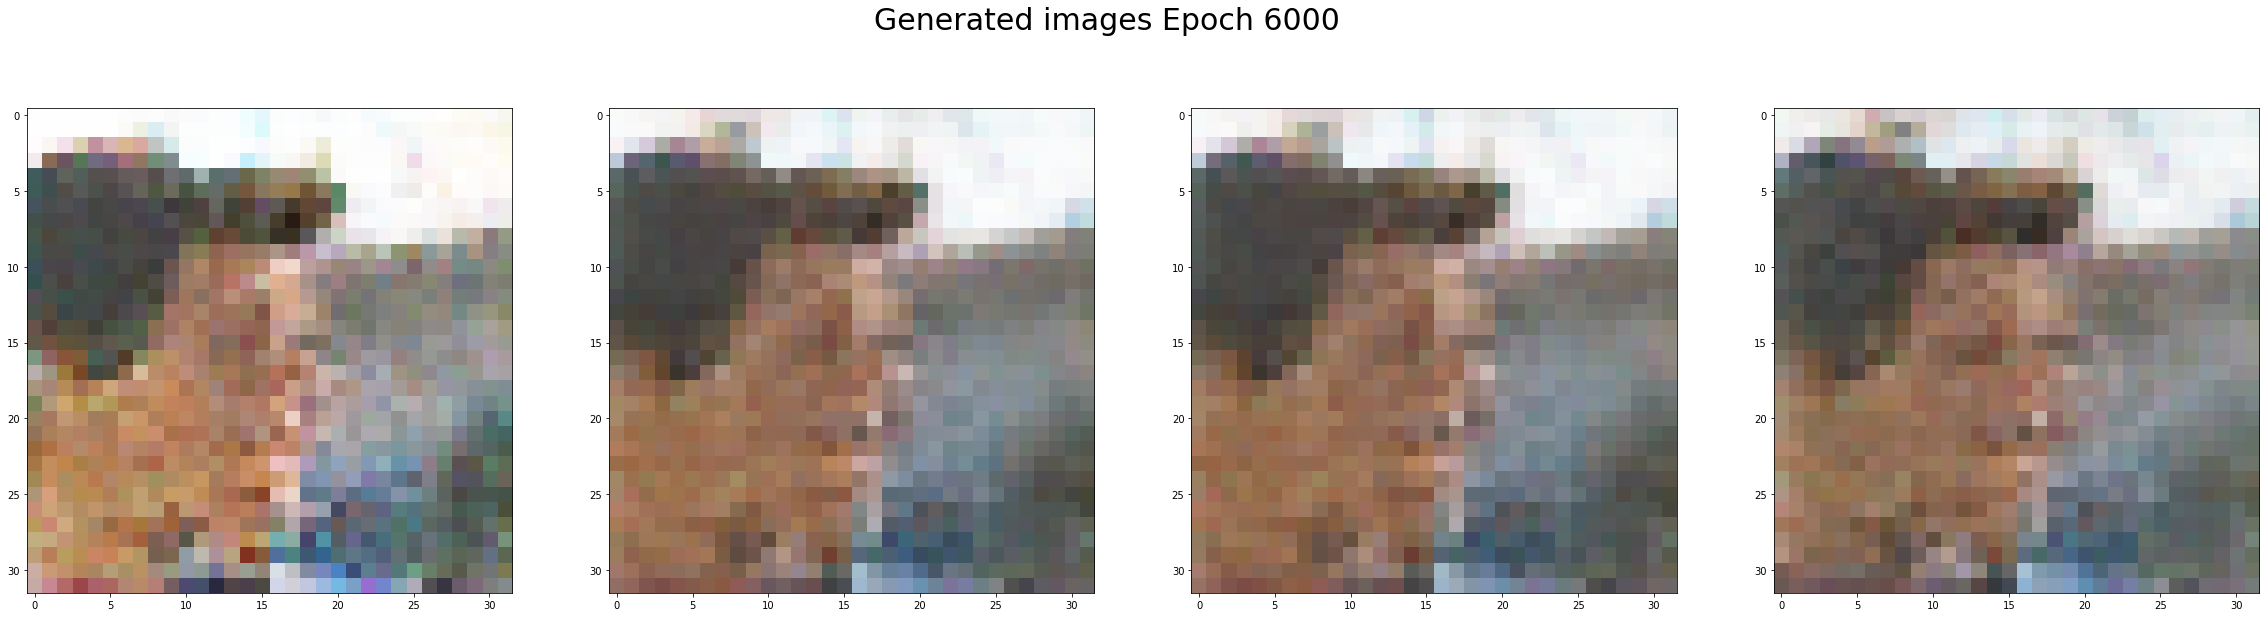

Epoch 06100 [D loss: 0.062, acc.: 098.0%] [G loss: 6.267]
Epoch 06200 [D loss: 0.059, acc.: 098.5%] [G loss: 6.459]
Epoch 06300 [D loss: 0.068, acc.: 098.0%] [G loss: 6.149]
Epoch 06400 [D loss: 0.052, acc.: 099.0%] [G loss: 5.956]
Epoch 06500 [D loss: 0.056, acc.: 098.1%] [G loss: 5.865]
Epoch 06600 [D loss: 0.047, acc.: 098.5%] [G loss: 6.008]
Epoch 06700 [D loss: 0.046, acc.: 098.6%] [G loss: 5.645]
Epoch 06800 [D loss: 0.035, acc.: 098.4%] [G loss: 6.172]
Epoch 06900 [D loss: 0.037, acc.: 098.5%] [G loss: 5.956]
Epoch 07000 [D loss: 0.061, acc.: 097.9%] [G loss: 5.743]


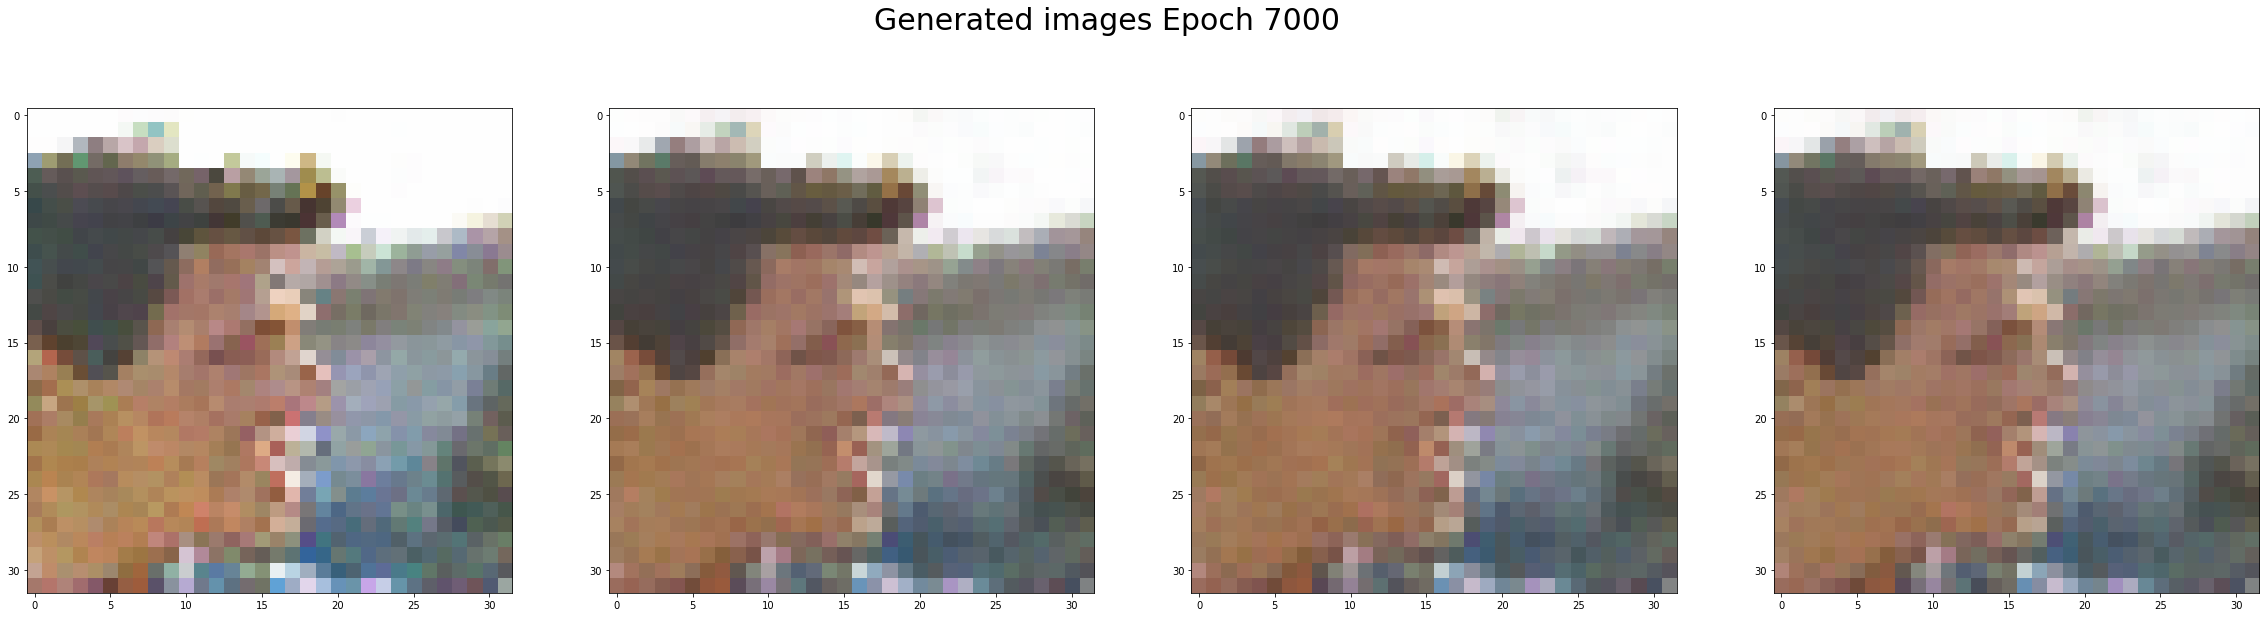

Epoch 07100 [D loss: 0.039, acc.: 098.8%] [G loss: 5.427]
Epoch 07200 [D loss: 0.062, acc.: 097.9%] [G loss: 5.353]
Epoch 07300 [D loss: 0.055, acc.: 098.7%] [G loss: 5.495]
Epoch 07400 [D loss: 0.032, acc.: 099.1%] [G loss: 5.477]
Epoch 07500 [D loss: 0.060, acc.: 098.1%] [G loss: 5.153]
Epoch 07600 [D loss: 0.041, acc.: 098.8%] [G loss: 5.574]
Epoch 07700 [D loss: 0.039, acc.: 098.9%] [G loss: 5.132]
Epoch 07800 [D loss: 0.071, acc.: 097.9%] [G loss: 5.326]
Epoch 07900 [D loss: 0.083, acc.: 098.3%] [G loss: 5.754]
Epoch 08000 [D loss: 0.069, acc.: 098.0%] [G loss: 5.239]


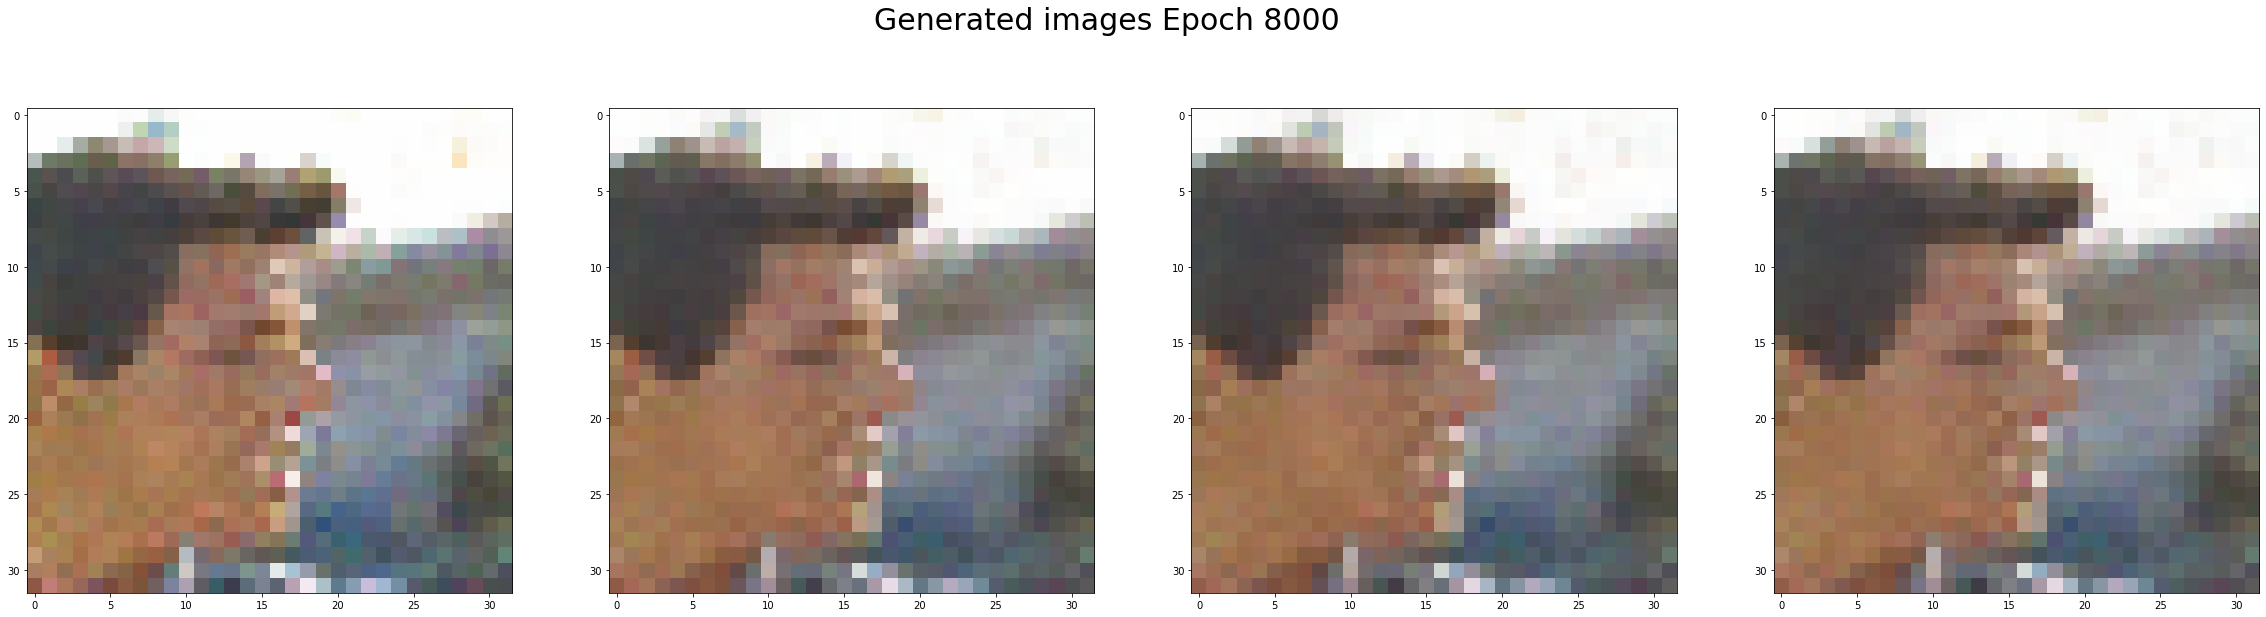

Epoch 08100 [D loss: 0.090, acc.: 097.7%] [G loss: 5.023]
Epoch 08200 [D loss: 0.082, acc.: 097.9%] [G loss: 5.897]
Epoch 08300 [D loss: 0.060, acc.: 098.1%] [G loss: 5.328]
Epoch 08400 [D loss: 0.047, acc.: 098.8%] [G loss: 5.466]
Epoch 08500 [D loss: 0.075, acc.: 098.0%] [G loss: 5.142]
Epoch 08600 [D loss: 0.060, acc.: 098.3%] [G loss: 5.520]
Epoch 08700 [D loss: 0.052, acc.: 098.4%] [G loss: 5.222]
Epoch 08800 [D loss: 0.066, acc.: 098.3%] [G loss: 5.567]
Epoch 08900 [D loss: 0.053, acc.: 098.2%] [G loss: 5.302]
Epoch 09000 [D loss: 0.093, acc.: 097.6%] [G loss: 4.853]


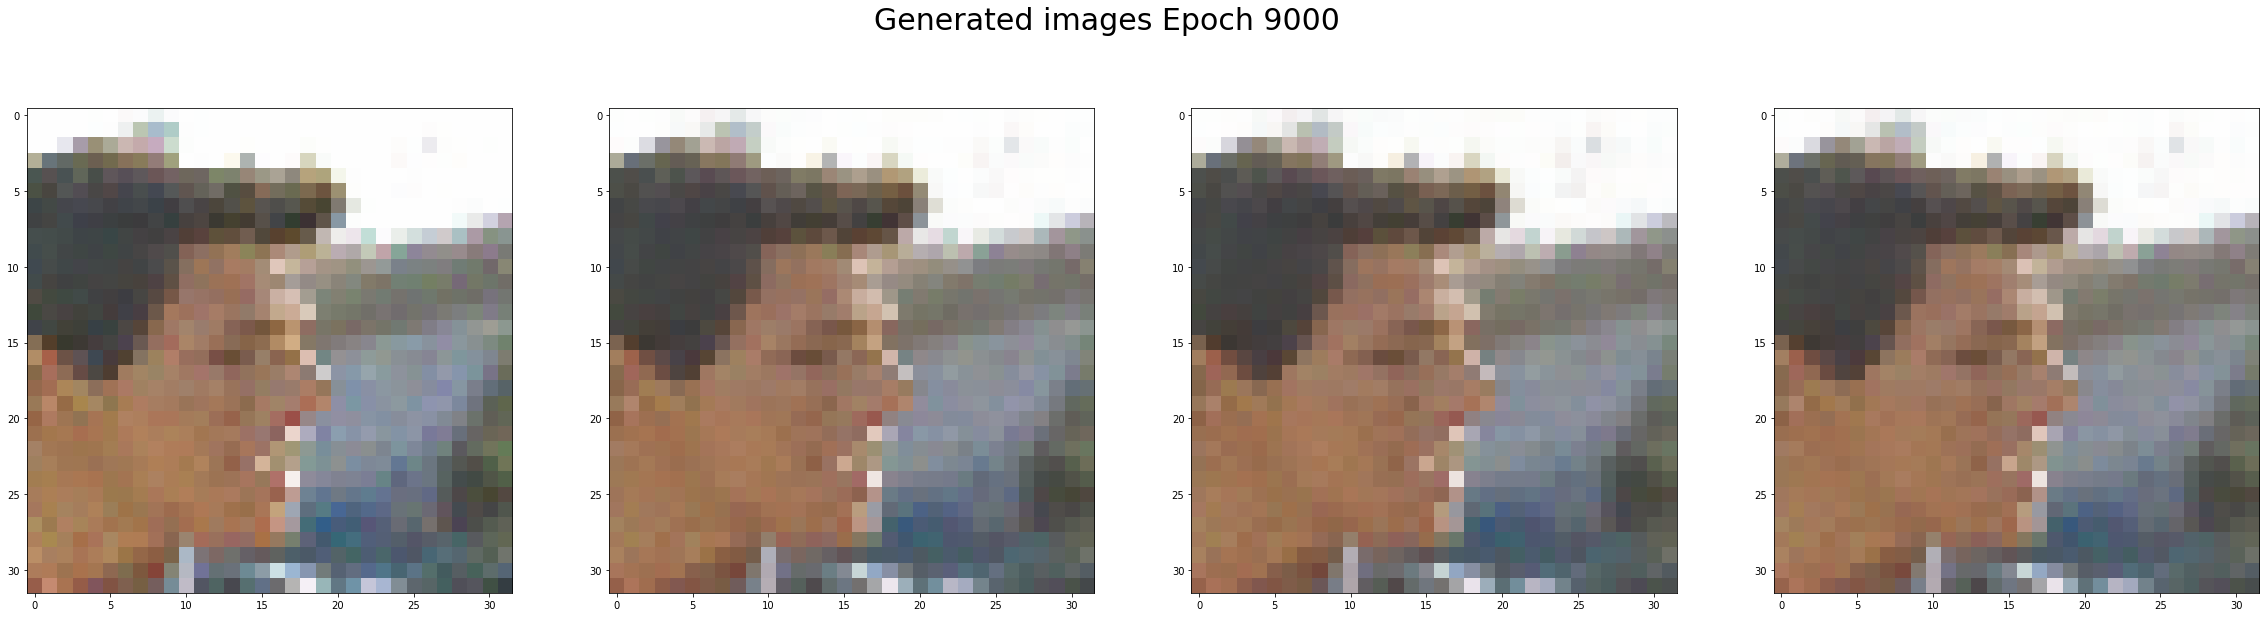

Epoch 09100 [D loss: 0.048, acc.: 098.5%] [G loss: 5.486]
Epoch 09200 [D loss: 0.054, acc.: 098.4%] [G loss: 5.106]
Epoch 09300 [D loss: 0.110, acc.: 098.0%] [G loss: 5.096]
Epoch 09400 [D loss: 0.089, acc.: 098.0%] [G loss: 5.107]
Epoch 09500 [D loss: 0.080, acc.: 098.2%] [G loss: 5.120]
Epoch 09600 [D loss: 0.051, acc.: 098.4%] [G loss: 5.196]
Epoch 09700 [D loss: 0.043, acc.: 098.8%] [G loss: 4.975]
Epoch 09800 [D loss: 0.067, acc.: 097.9%] [G loss: 5.578]
Epoch 09900 [D loss: 0.088, acc.: 097.6%] [G loss: 4.802]
Epoch 10000 [D loss: 0.090, acc.: 098.3%] [G loss: 4.768]


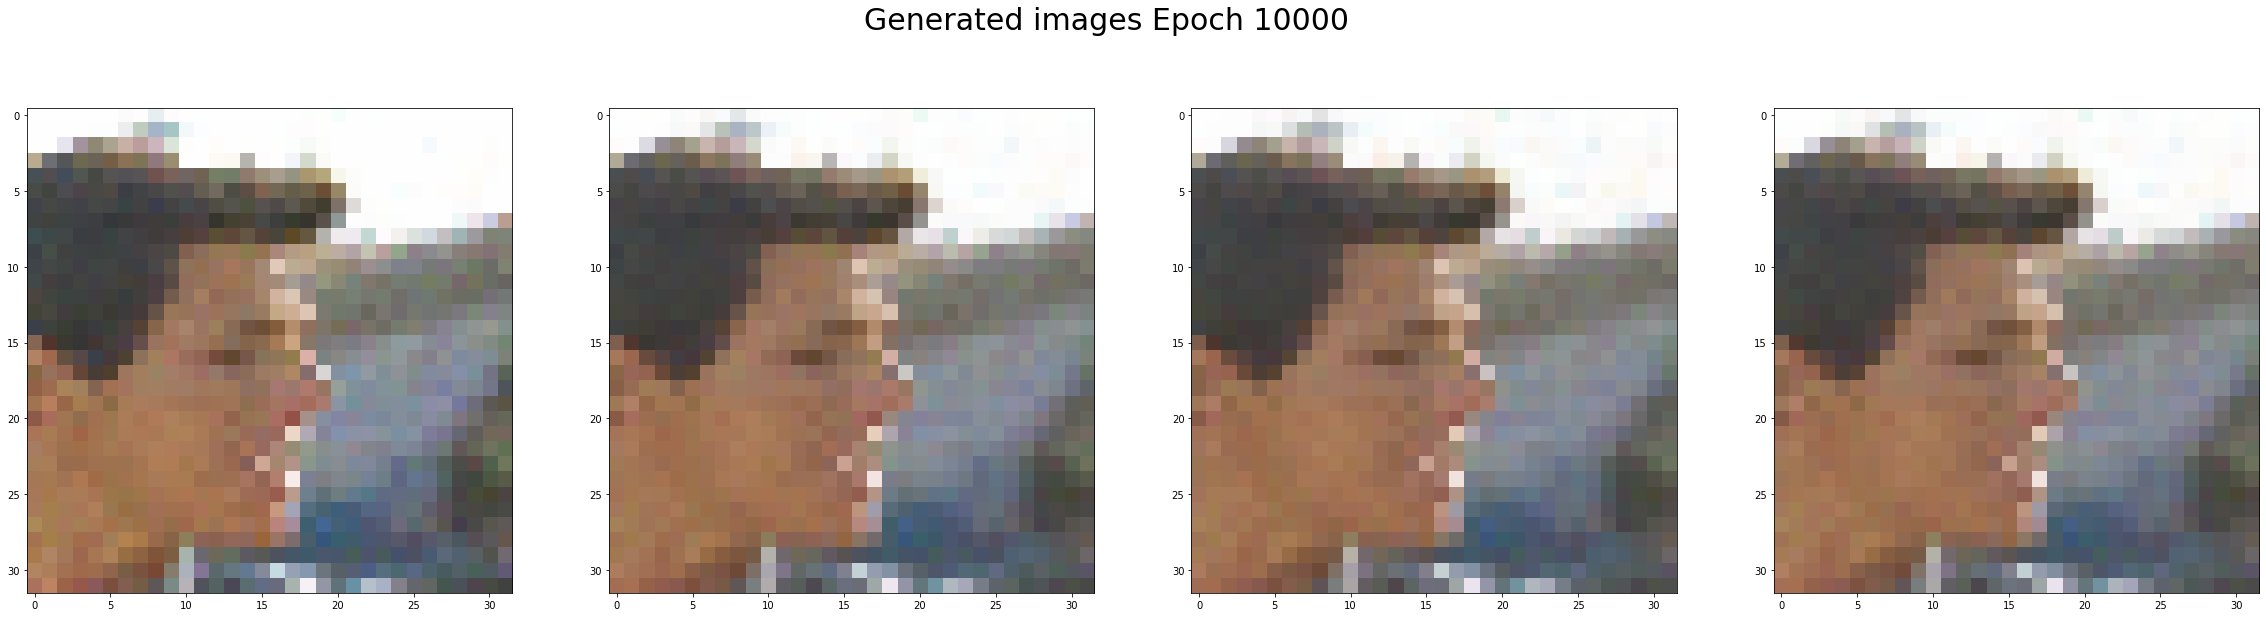

Epoch 10100 [D loss: 0.061, acc.: 098.5%] [G loss: 4.583]
Epoch 10200 [D loss: 0.043, acc.: 098.8%] [G loss: 4.979]
Epoch 10300 [D loss: 0.068, acc.: 098.0%] [G loss: 4.701]
Epoch 10400 [D loss: 0.048, acc.: 098.6%] [G loss: 4.927]
Epoch 10500 [D loss: 0.031, acc.: 099.1%] [G loss: 5.373]
Epoch 10600 [D loss: 0.055, acc.: 098.5%] [G loss: 4.849]
Epoch 10700 [D loss: 0.074, acc.: 097.9%] [G loss: 5.108]
Epoch 10800 [D loss: 0.053, acc.: 098.6%] [G loss: 4.805]
Epoch 10900 [D loss: 0.059, acc.: 098.3%] [G loss: 5.323]
Epoch 11000 [D loss: 0.060, acc.: 098.3%] [G loss: 4.672]


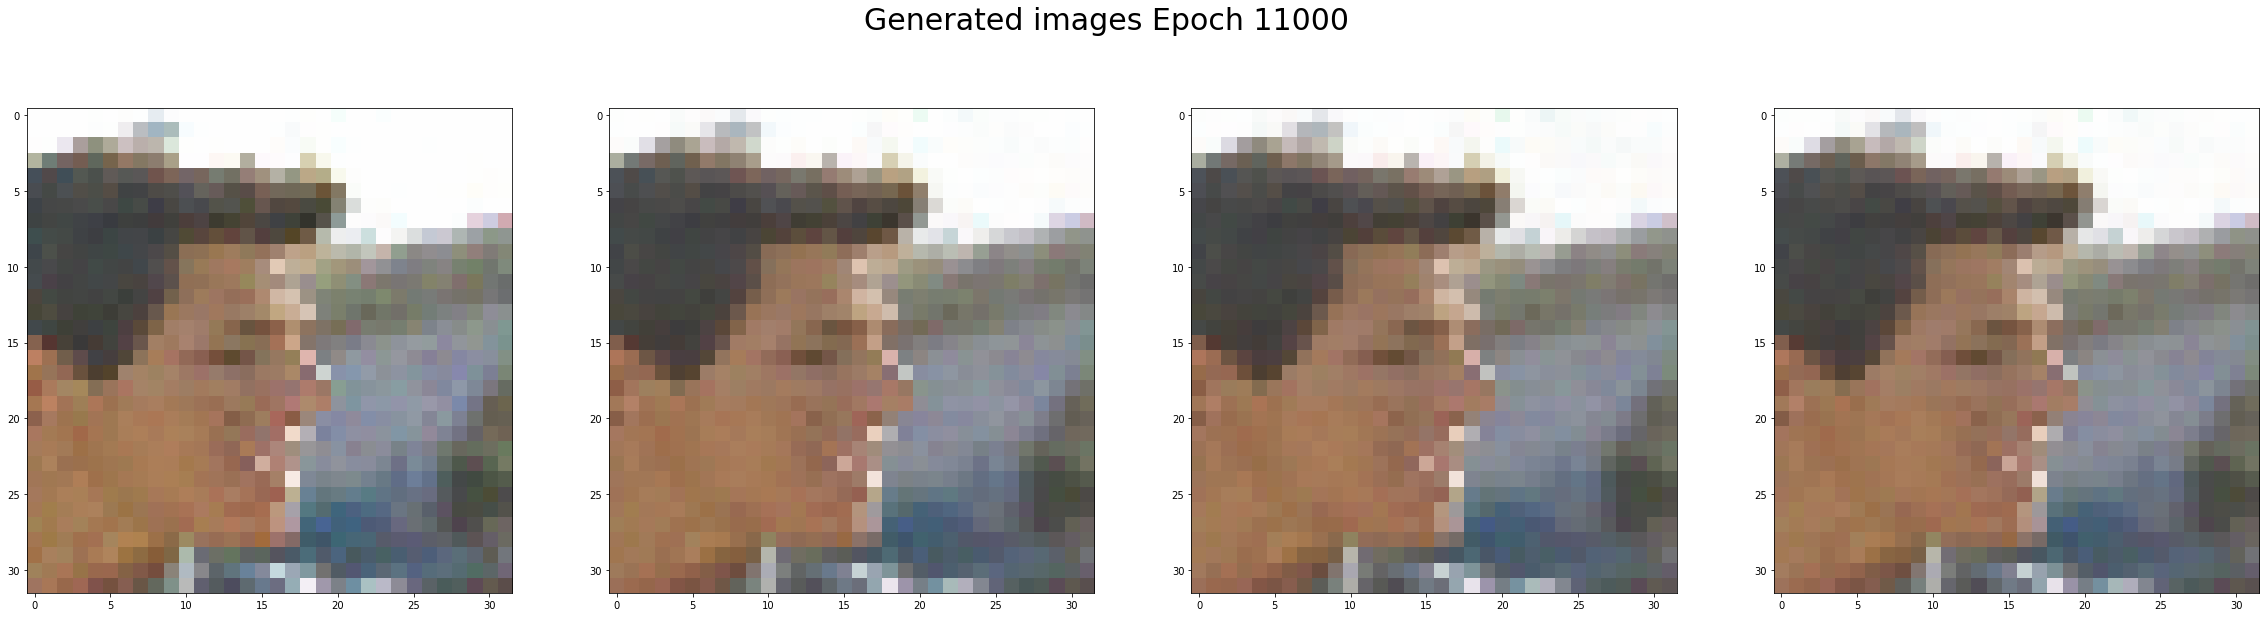

Epoch 11100 [D loss: 0.082, acc.: 097.9%] [G loss: 5.119]
Epoch 11200 [D loss: 0.070, acc.: 097.9%] [G loss: 5.081]
Epoch 11300 [D loss: 0.041, acc.: 098.9%] [G loss: 5.147]
Epoch 11400 [D loss: 0.074, acc.: 098.2%] [G loss: 5.911]
Epoch 11500 [D loss: 0.043, acc.: 098.7%] [G loss: 4.916]
Epoch 11600 [D loss: 0.084, acc.: 097.7%] [G loss: 4.543]
Epoch 11700 [D loss: 0.070, acc.: 097.9%] [G loss: 5.655]
Epoch 11800 [D loss: 0.043, acc.: 098.8%] [G loss: 4.952]
Epoch 11900 [D loss: 0.083, acc.: 097.7%] [G loss: 4.541]
Epoch 12000 [D loss: 0.063, acc.: 098.5%] [G loss: 5.077]


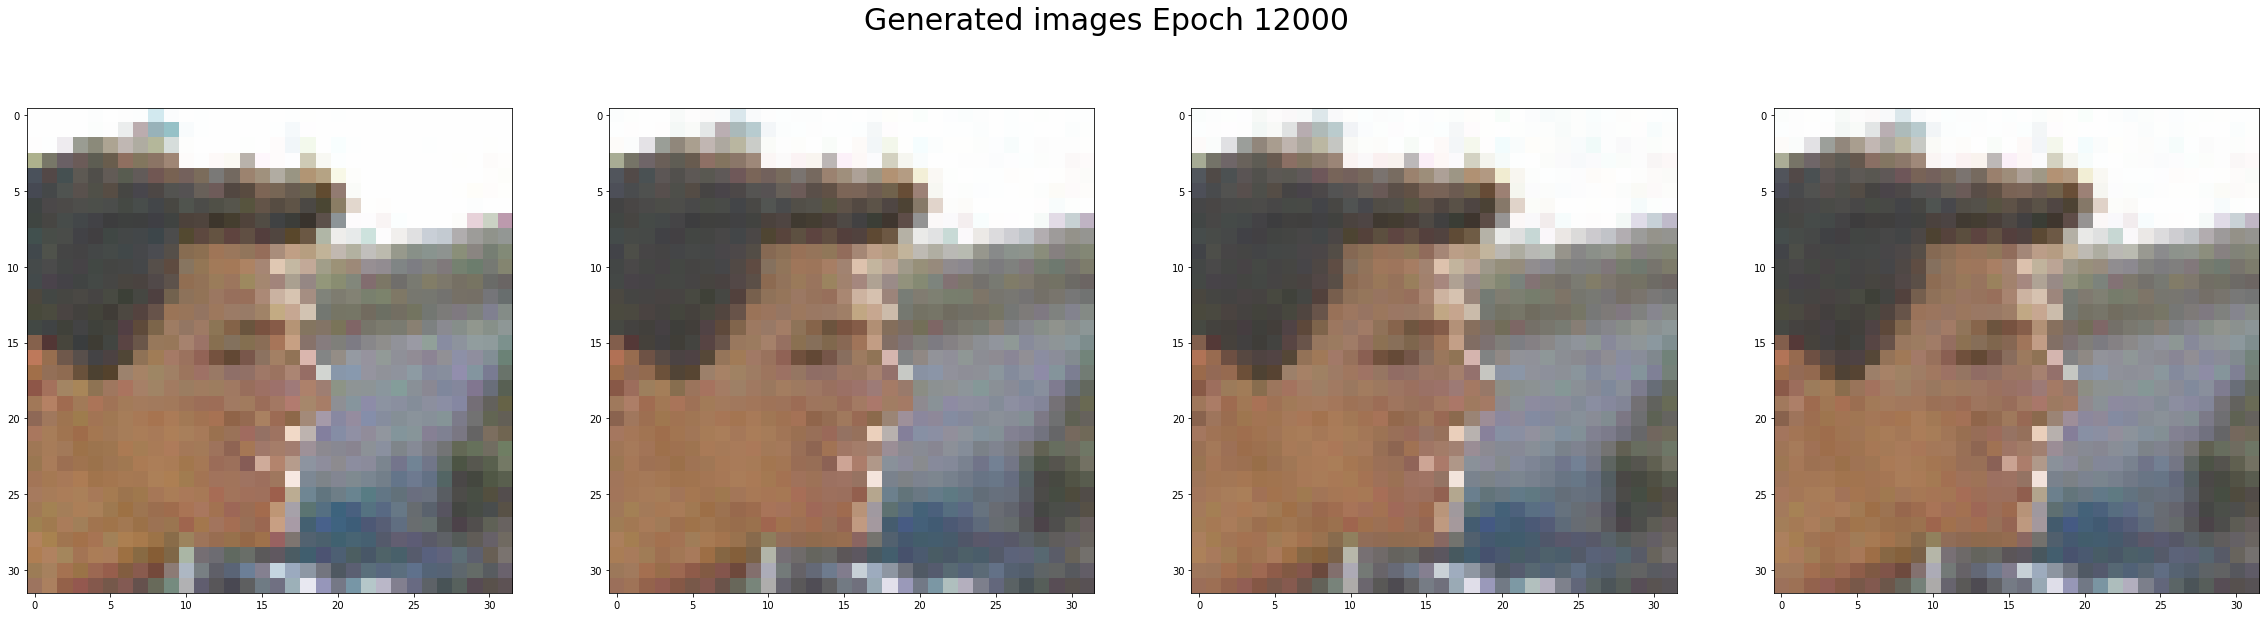

Epoch 12100 [D loss: 0.045, acc.: 098.8%] [G loss: 4.925]
Epoch 12200 [D loss: 0.076, acc.: 098.2%] [G loss: 5.024]
Epoch 12300 [D loss: 0.050, acc.: 098.6%] [G loss: 5.165]
Epoch 12400 [D loss: 0.091, acc.: 097.7%] [G loss: 5.251]
Epoch 12500 [D loss: 0.082, acc.: 097.9%] [G loss: 4.934]
Epoch 12600 [D loss: 0.059, acc.: 098.2%] [G loss: 4.855]
Epoch 12700 [D loss: 0.072, acc.: 098.1%] [G loss: 5.144]
Epoch 12800 [D loss: 0.050, acc.: 098.6%] [G loss: 4.748]
Epoch 12900 [D loss: 0.094, acc.: 098.1%] [G loss: 4.782]
Epoch 13000 [D loss: 0.073, acc.: 098.1%] [G loss: 4.954]


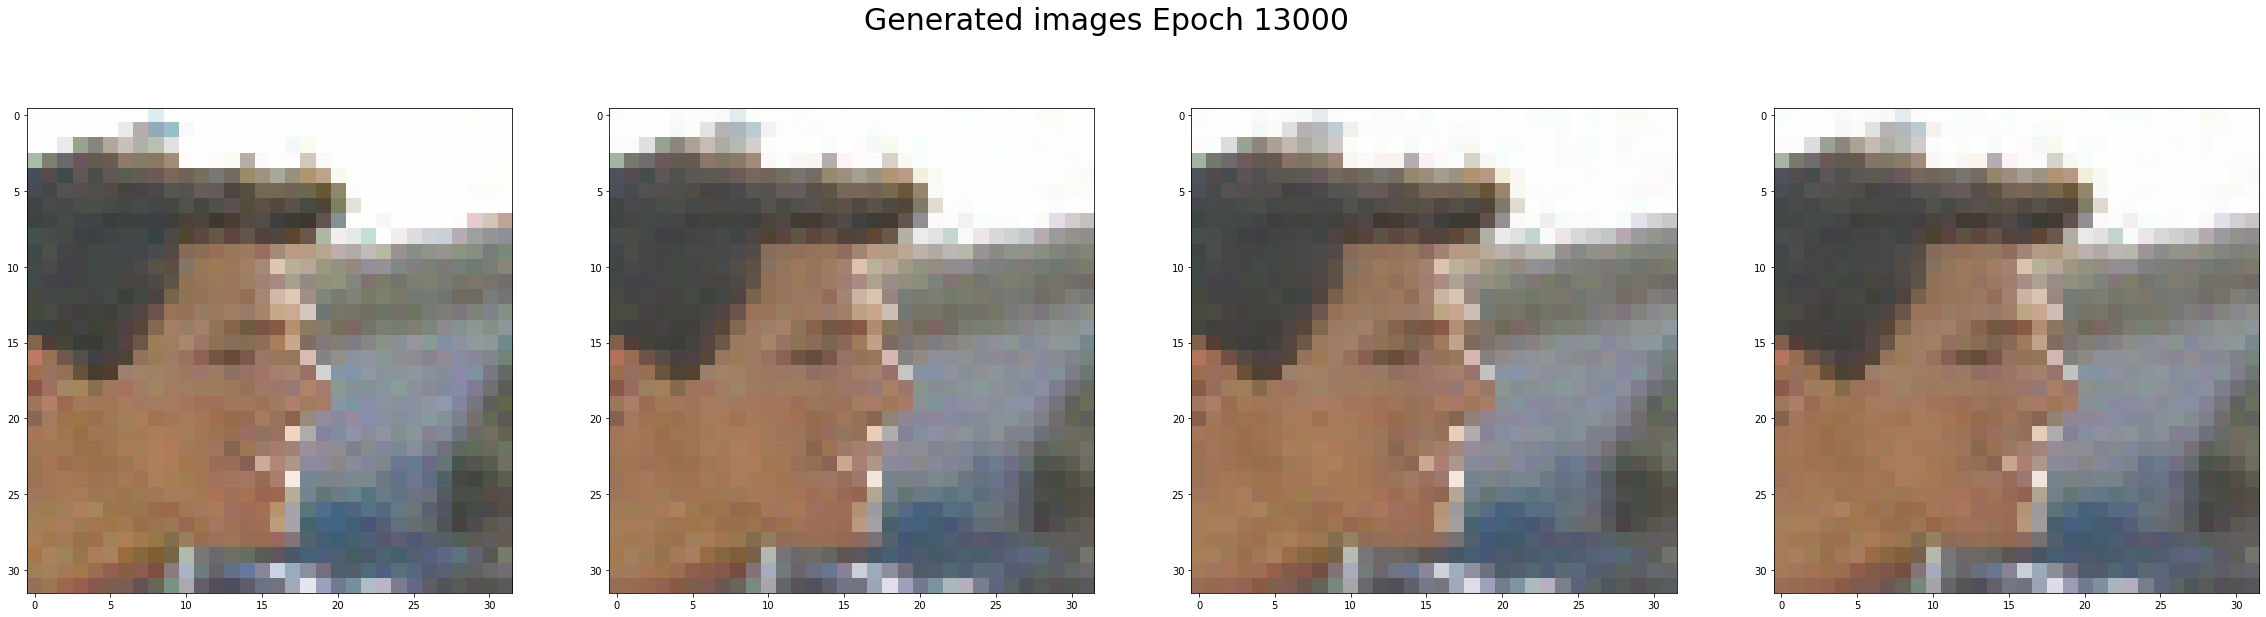

Epoch 13100 [D loss: 0.078, acc.: 097.6%] [G loss: 5.106]
Epoch 13200 [D loss: 0.070, acc.: 097.9%] [G loss: 4.922]
Epoch 13300 [D loss: 0.071, acc.: 097.8%] [G loss: 4.986]
Epoch 13400 [D loss: 0.071, acc.: 098.0%] [G loss: 4.490]
Epoch 13500 [D loss: 0.058, acc.: 098.3%] [G loss: 5.087]
Epoch 13600 [D loss: 0.066, acc.: 097.9%] [G loss: 5.271]
Epoch 13700 [D loss: 0.055, acc.: 098.6%] [G loss: 5.556]
Epoch 13800 [D loss: 0.041, acc.: 098.8%] [G loss: 4.917]
Epoch 13900 [D loss: 0.054, acc.: 098.4%] [G loss: 5.153]
Epoch 14000 [D loss: 0.074, acc.: 097.8%] [G loss: 4.841]


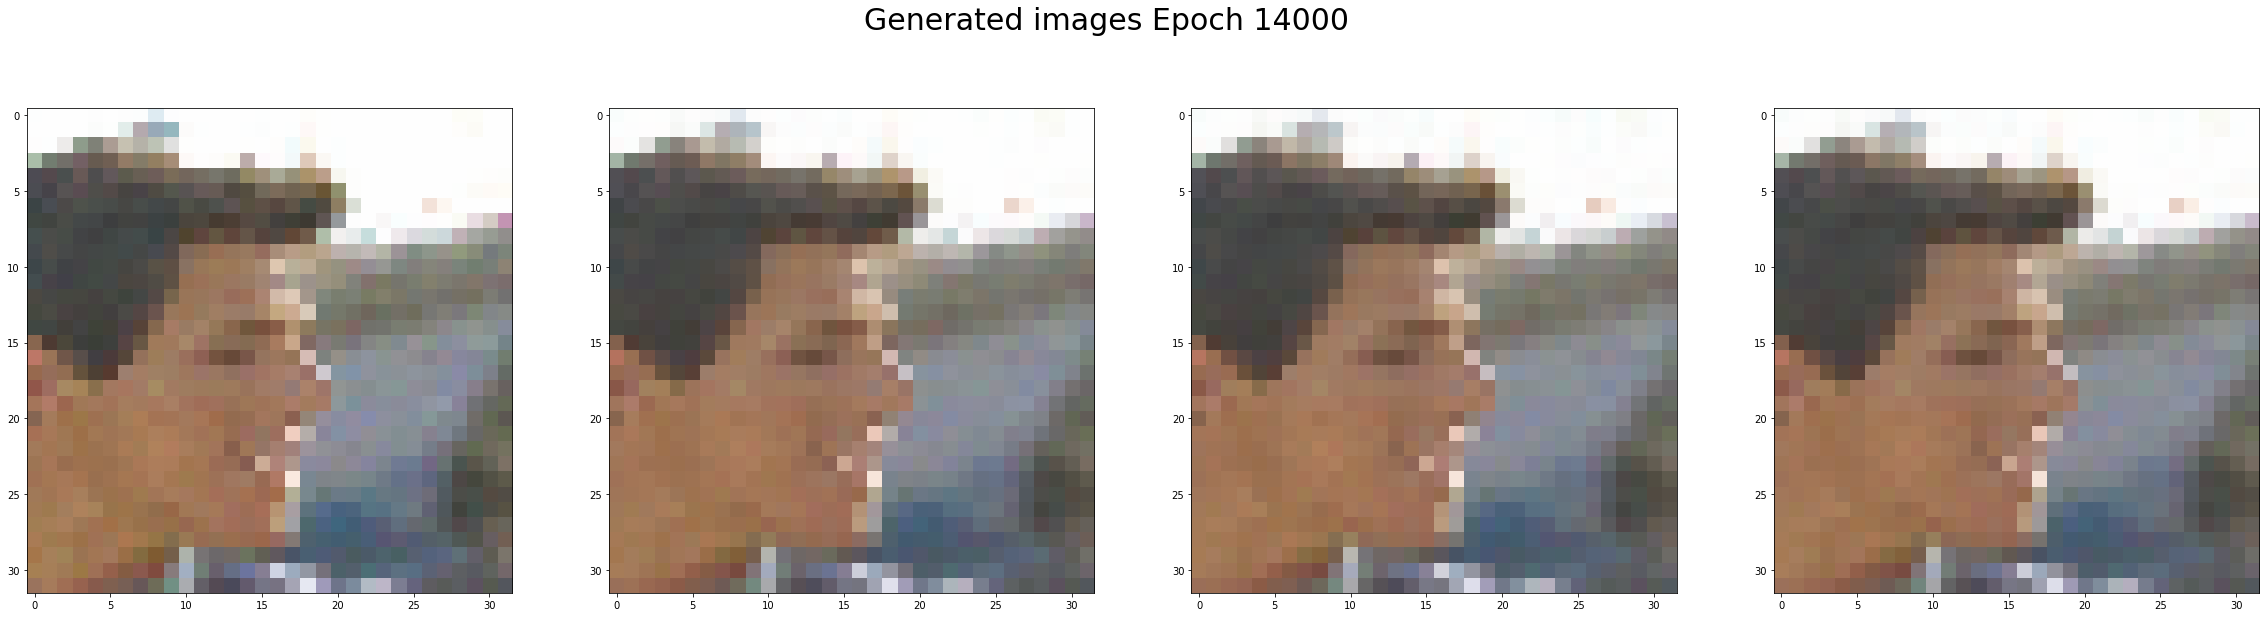

Epoch 14100 [D loss: 0.043, acc.: 098.8%] [G loss: 4.937]
Epoch 14200 [D loss: 0.047, acc.: 098.7%] [G loss: 4.850]
Epoch 14300 [D loss: 0.071, acc.: 097.9%] [G loss: 5.728]
Epoch 14400 [D loss: 0.047, acc.: 098.5%] [G loss: 5.611]
Epoch 14500 [D loss: 0.033, acc.: 099.0%] [G loss: 5.183]
Epoch 14600 [D loss: 0.077, acc.: 098.1%] [G loss: 4.830]
Epoch 14700 [D loss: 0.088, acc.: 098.0%] [G loss: 5.478]
Epoch 14800 [D loss: 0.052, acc.: 098.5%] [G loss: 5.026]
Epoch 14900 [D loss: 0.063, acc.: 097.9%] [G loss: 4.933]
Epoch 15000 [D loss: 0.074, acc.: 097.9%] [G loss: 4.875]


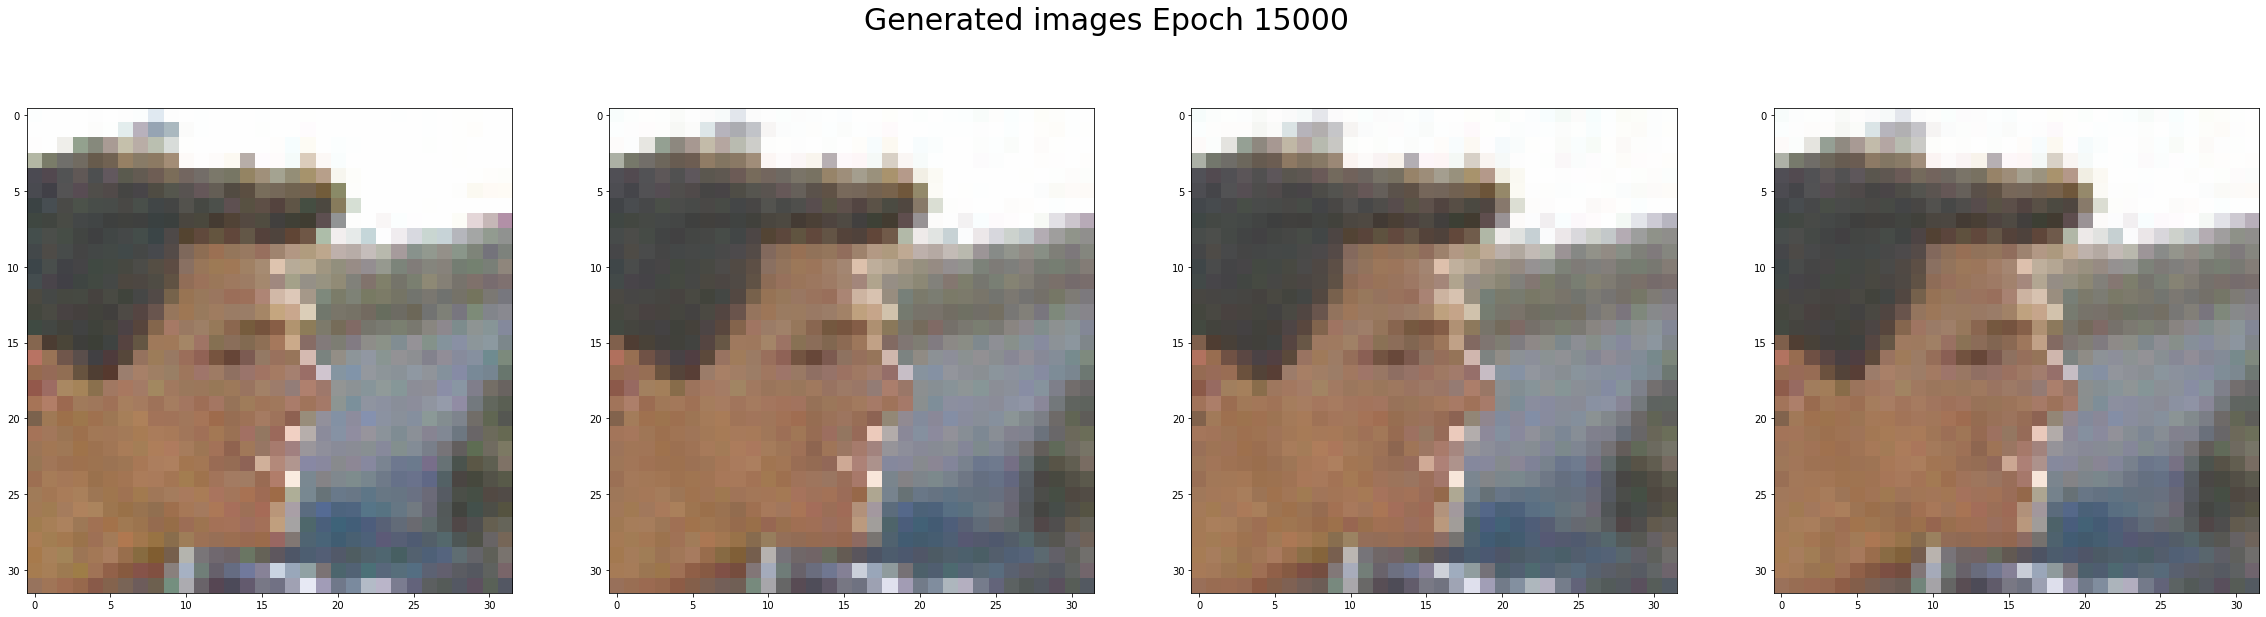

Epoch 15100 [D loss: 0.028, acc.: 099.0%] [G loss: 5.346]
Epoch 15200 [D loss: 0.056, acc.: 098.5%] [G loss: 4.681]
Epoch 15300 [D loss: 0.054, acc.: 098.3%] [G loss: 5.139]
Epoch 15400 [D loss: 0.066, acc.: 098.1%] [G loss: 4.789]
Epoch 15500 [D loss: 0.066, acc.: 098.7%] [G loss: 5.072]
Epoch 15600 [D loss: 0.030, acc.: 099.2%] [G loss: 5.258]
Epoch 15700 [D loss: 0.063, acc.: 098.8%] [G loss: 4.632]
Epoch 15800 [D loss: 0.051, acc.: 098.2%] [G loss: 5.220]
Epoch 15900 [D loss: 0.037, acc.: 098.9%] [G loss: 4.801]
Epoch 16000 [D loss: 0.080, acc.: 097.8%] [G loss: 4.510]


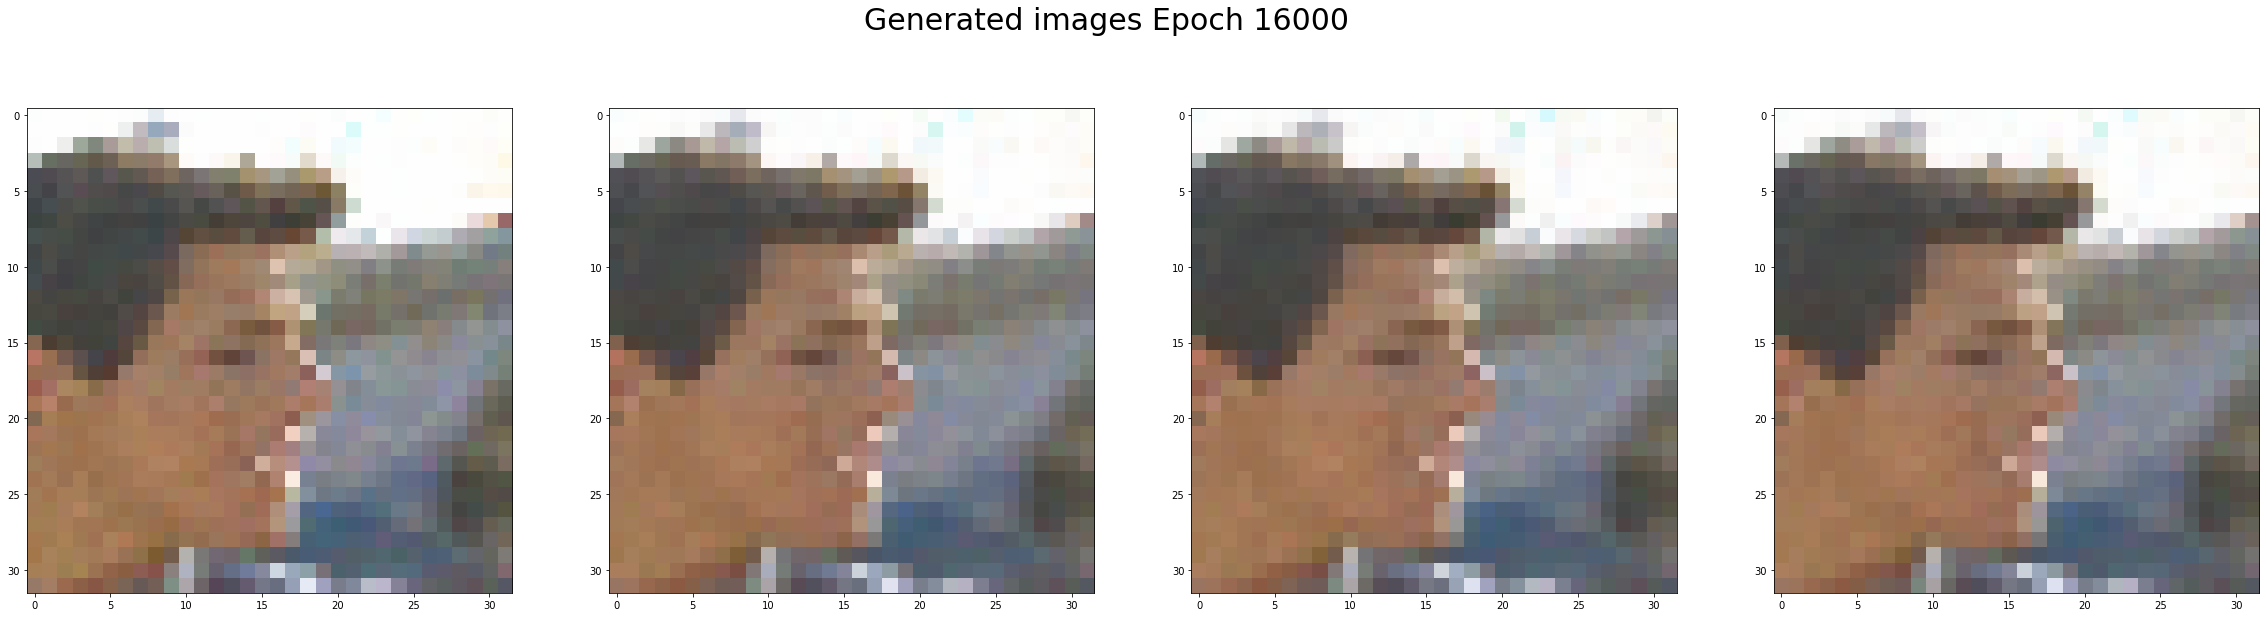

Epoch 16100 [D loss: 0.091, acc.: 097.5%] [G loss: 5.226]
Epoch 16200 [D loss: 0.062, acc.: 098.2%] [G loss: 4.779]
Epoch 16300 [D loss: 0.063, acc.: 098.3%] [G loss: 4.329]
Epoch 16400 [D loss: 0.022, acc.: 099.8%] [G loss: 5.416]
Epoch 16500 [D loss: 0.054, acc.: 098.3%] [G loss: 5.140]
Epoch 16600 [D loss: 0.046, acc.: 098.5%] [G loss: 4.645]
Epoch 16700 [D loss: 0.072, acc.: 097.9%] [G loss: 4.252]
Epoch 16800 [D loss: 0.061, acc.: 098.3%] [G loss: 6.237]
Epoch 16900 [D loss: 0.045, acc.: 098.4%] [G loss: 5.209]
Epoch 17000 [D loss: 0.060, acc.: 098.0%] [G loss: 4.916]


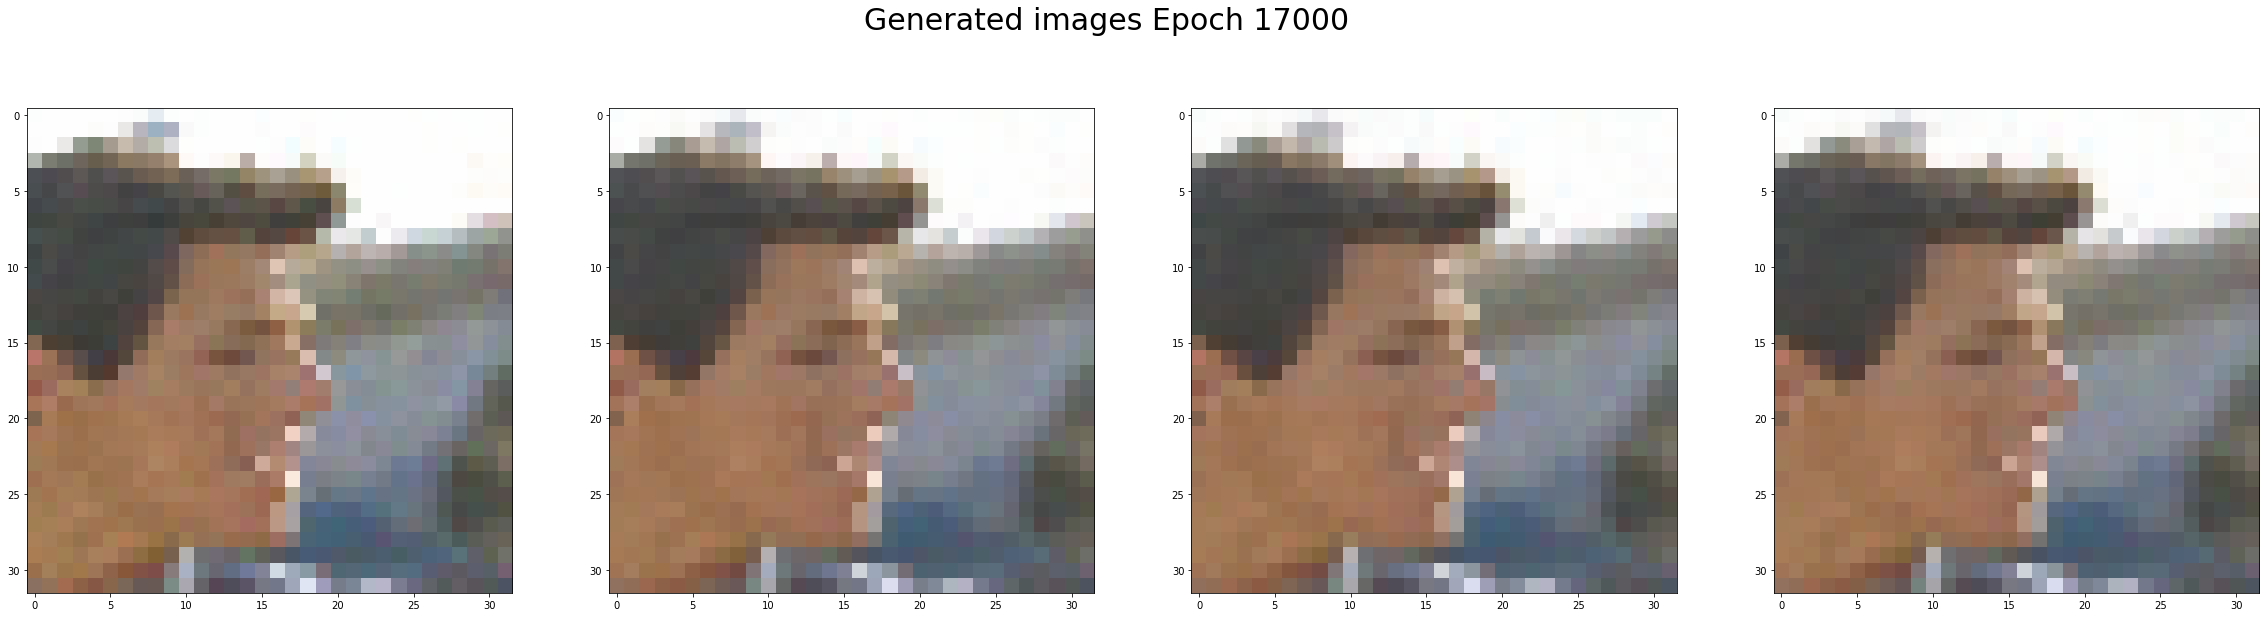

Epoch 17100 [D loss: 0.095, acc.: 098.2%] [G loss: 4.579]
Epoch 17200 [D loss: 0.030, acc.: 098.7%] [G loss: 5.051]
Epoch 17300 [D loss: 0.054, acc.: 098.3%] [G loss: 4.928]
Epoch 17400 [D loss: 0.050, acc.: 098.6%] [G loss: 5.134]
Epoch 17500 [D loss: 0.039, acc.: 099.3%] [G loss: 5.006]
Epoch 17600 [D loss: 0.038, acc.: 099.2%] [G loss: 5.013]
Epoch 17700 [D loss: 0.075, acc.: 097.2%] [G loss: 4.829]
Epoch 17800 [D loss: 0.055, acc.: 098.5%] [G loss: 5.200]
Epoch 17900 [D loss: 0.036, acc.: 099.3%] [G loss: 4.719]
Epoch 18000 [D loss: 0.057, acc.: 098.6%] [G loss: 4.692]


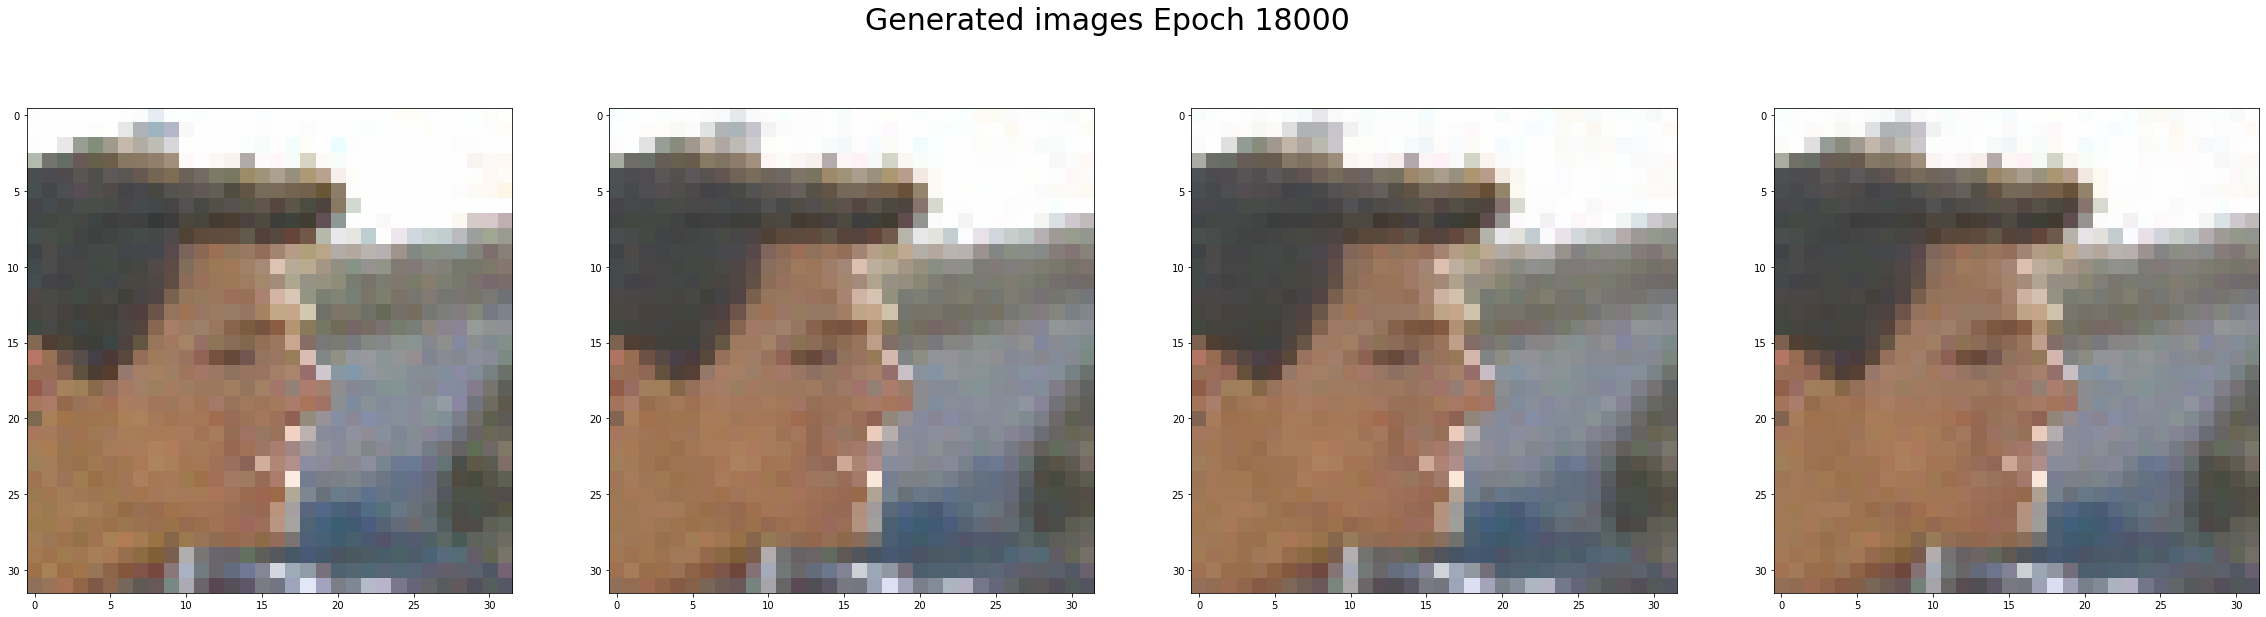

Epoch 18100 [D loss: 0.073, acc.: 097.9%] [G loss: 4.567]
Epoch 18200 [D loss: 0.051, acc.: 098.6%] [G loss: 5.067]
Epoch 18300 [D loss: 0.060, acc.: 098.4%] [G loss: 5.088]
Epoch 18400 [D loss: 0.054, acc.: 098.6%] [G loss: 4.951]
Epoch 18500 [D loss: 0.059, acc.: 098.3%] [G loss: 4.859]
Epoch 18600 [D loss: 0.041, acc.: 098.7%] [G loss: 4.879]
Epoch 18700 [D loss: 0.058, acc.: 098.3%] [G loss: 4.859]
Epoch 18800 [D loss: 0.049, acc.: 099.0%] [G loss: 5.094]
Epoch 18900 [D loss: 0.057, acc.: 098.4%] [G loss: 4.278]
Epoch 19000 [D loss: 0.071, acc.: 097.6%] [G loss: 4.841]


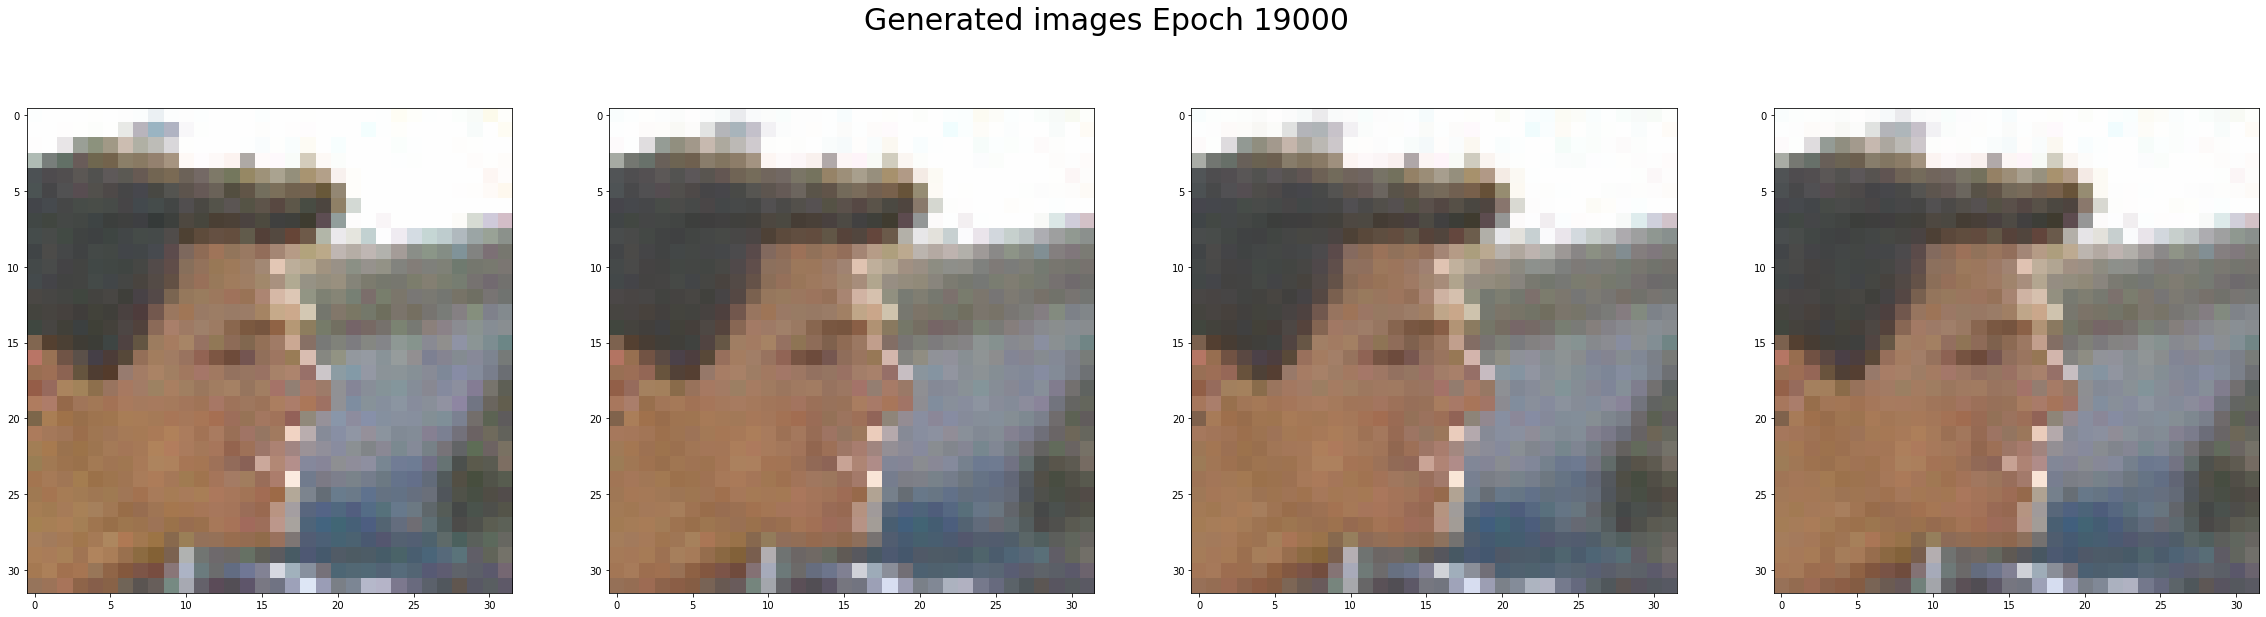

Epoch 19100 [D loss: 0.034, acc.: 099.1%] [G loss: 5.079]
Epoch 19200 [D loss: 0.046, acc.: 098.2%] [G loss: 4.722]
Epoch 19300 [D loss: 0.038, acc.: 099.5%] [G loss: 5.091]
Epoch 19400 [D loss: 0.041, acc.: 098.9%] [G loss: 6.104]
Epoch 19500 [D loss: 0.066, acc.: 098.5%] [G loss: 5.118]
Epoch 19600 [D loss: 0.060, acc.: 097.9%] [G loss: 4.524]
Epoch 19700 [D loss: 0.044, acc.: 098.7%] [G loss: 4.990]
Epoch 19800 [D loss: 0.076, acc.: 098.0%] [G loss: 4.414]
Epoch 19900 [D loss: 0.040, acc.: 099.1%] [G loss: 5.606]
----------
Time took: 114.16 min


In [10]:
 def train(models, X_train, noise_plot, dir_result="/result/", epochs=10000, batch_size=128):
        
        '''
        models     : tuple containins three tensors, (combined, discriminator, generator)
        X_train    : np.array containing images (Nsample, height, width, Nchannels)
        noise_plot : np.array of size (Nrandom_sample_to_plot, hidden unit length)
        dir_result : the location where the generated plots for noise_plot are saved 
        
        '''
        combined, discriminator, generator = models
        nlatent_dim = noise_plot.shape[1]
        half_batch  = int(batch_size / 2)
        history = []
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
            noise = get_noise(half_batch, nlatent_dim)

            # Generate a half batch of new images
            gen_imgs = generator.predict(noise)

            
            # Train the discriminator q: better to mix them together?
            d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = get_noise(batch_size, nlatent_dim)

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = (np.array([1] * batch_size)).reshape(batch_size,1)
            
            # Train the generator
            g_loss = combined.train_on_batch(noise, valid_y)

            history.append({"D":d_loss[0],"G":g_loss})
            
            if epoch % 100 == 0:
                # Plot the progress
                print ("Epoch {:05.0f} [D loss: {:4.3f}, acc.: {:05.1f}%] [G loss: {:4.3f}]".format(
                    epoch, d_loss[0], 100*d_loss[1], g_loss))
            if epoch % int(epochs/100) == 0:
                plot_generated_images(noise_plot,
                                      path_save=dir_result+"/image_{:05.0f}.png".format(epoch),
                                      titleadd="Epoch {}".format(epoch))
            if epoch % 1000 == 0:
                plot_generated_images(noise_plot,
                                      titleadd="Epoch {}".format(epoch))
                        
        return(history)

dir_result="./result_GAN/"

try:
    os.mkdir(dir_result)
except:
    pass
    
start_time = time.time()

_models = combined, discriminator, generator          

history = train(_models, X_train, noise, dir_result=dir_result,epochs=20000, batch_size=128*8)
end_time = time.time()
print("-"*10)
print("Time took: {:4.2f} min".format((end_time - start_time)/60))

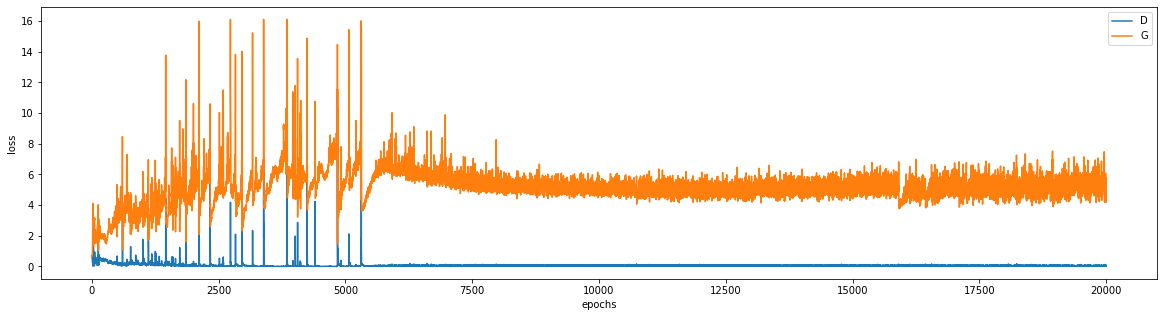

In [11]:
import pandas as pd 
hist = pd.DataFrame(history)
plt.figure(figsize=(20,5))
for colnm in hist.columns:
    plt.plot(hist[colnm],label=colnm)
plt.legend()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

In [0]:
def makegif(dir_images):
    import imageio
    filenames = np.sort(os.listdir(dir_images))
    filenames = [ fnm for fnm in filenames if ".png" in fnm]

    with imageio.get_writer(dir_images + '/image.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(dir_images + filename)
            writer.append_data(image)
            os.remove(dir_images + filename)
            
makegif(dir_result)

In [13]:
img_in = layers.Input(shape=img_shape)

# discriminator with the final output layer = 100 network as encoder
discriminator_encoder = build_discriminator(img_shape,100)

# discriminator as encoder
encoder = discriminator_encoder(img_in)

# generator as decoder
generator.trainable = False
img_out = generator(encoder) 

encoder_decoder = models.Model(img_in,img_out)
encoder_decoder.compile(loss='mse', optimizer=optimizer)

encoder_decoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
model_4 (Model)              (None, 100)               6813060   
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 3)         8584515   
Total params: 15,397,575
Trainable params: 6,813,060
Non-trainable params: 8,584,515
_________________________________________________________________


In [14]:
start_time = time.time()
history_ed = encoder_decoder.fit(X_train,X_train,
                                 validation_data=(X_test,X_test),
                                 epochs=10,verbose=2)
end_time = time.time()
print("-"*10)
print("Time took: {:4.2f} min".format((end_time - start_time)/60))

Train on 60 samples, validate on 40 samples
Epoch 1/10
 - 1s - loss: 0.1262 - val_loss: 0.1316
Epoch 2/10
 - 0s - loss: 0.1207 - val_loss: 0.1316
Epoch 3/10
 - 0s - loss: 0.1206 - val_loss: 0.1314
Epoch 4/10
 - 0s - loss: 0.1203 - val_loss: 0.1303
Epoch 5/10
 - 0s - loss: 0.1163 - val_loss: 0.1889
Epoch 6/10
 - 0s - loss: 0.1419 - val_loss: 0.1301
Epoch 7/10
 - 0s - loss: 0.1196 - val_loss: 0.1311
Epoch 8/10
 - 0s - loss: 0.1202 - val_loss: 0.1312
Epoch 9/10
 - 0s - loss: 0.1202 - val_loss: 0.1311
Epoch 10/10
 - 0s - loss: 0.1202 - val_loss: 0.1310
----------
Time took: 0.04 min


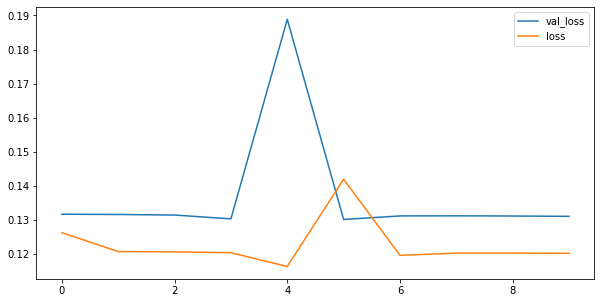

In [15]:
plt.figure(figsize=(10,5))
for colnm in history_ed.history.keys():
    plt.plot(history_ed.history[colnm],label=colnm)
plt.legend()
plt.show()

In [0]:
# discriminator_encoder.compile(loss='mse', optimizer=optimizer)
X_pred = encoder_decoder.predict(X_test)
## z_pred = discriminator_encoder.predict(X_test)

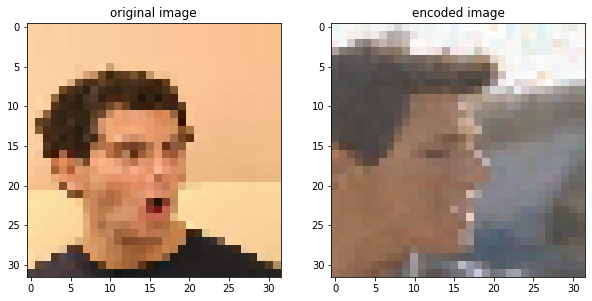

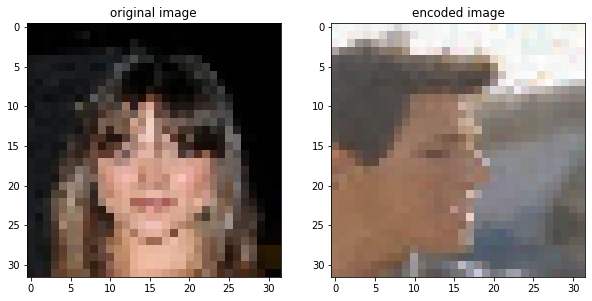

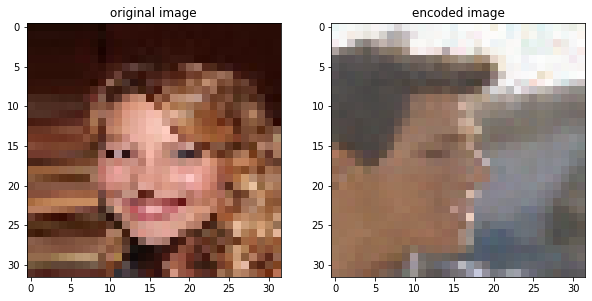

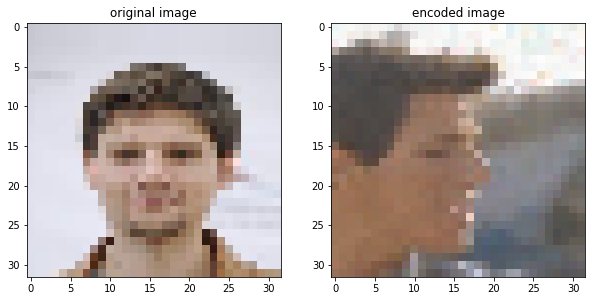

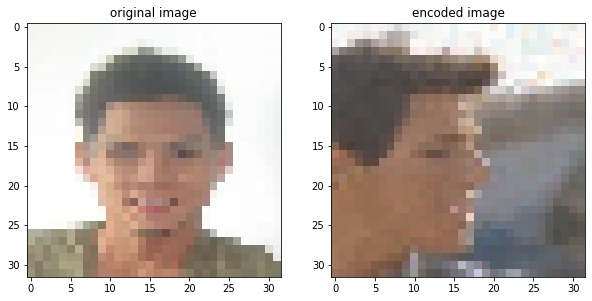

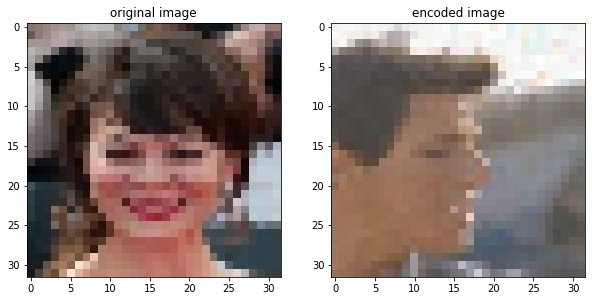

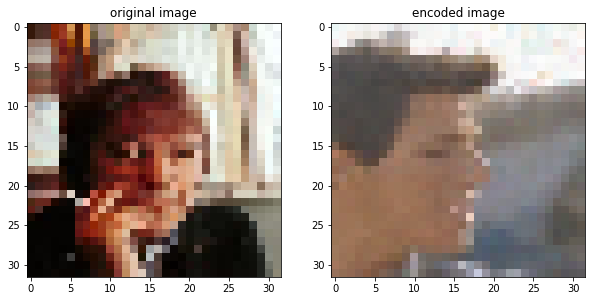

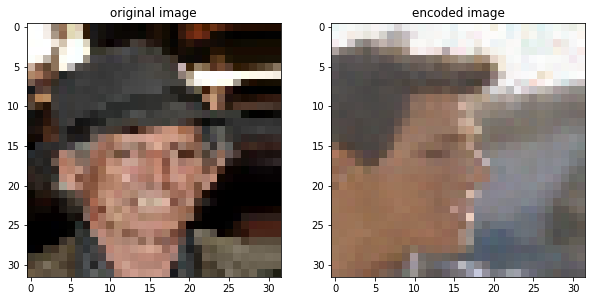

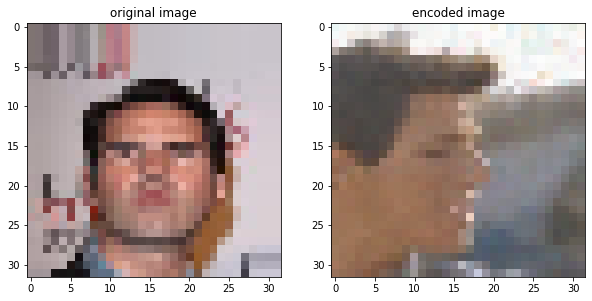

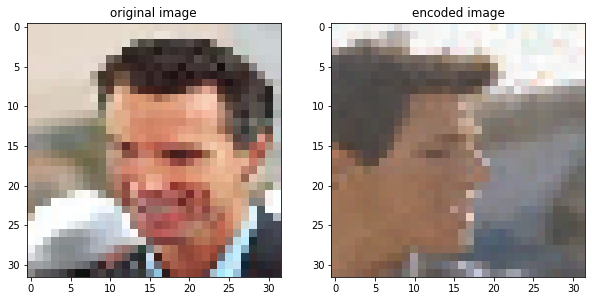

In [17]:
Ntest = 10

for irow in range(Ntest):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,2,1)
    ax.imshow(X_test[irow])
    ax.set_title("original image")
    
    ax = fig.add_subplot(1,2,2)
    ax.imshow(X_pred[irow])
    ax.set_title("encoded image")
    
    plt.show()